In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from random import random
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import kurtosis
from ast import literal_eval
import seaborn as sns
from ast import literal_eval
from sklearn.metrics import *
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import scipy
from sklearn.metrics import *
import torch

# Optional imports

In [2]:
%%capture
!pip install --upgrade --no-cache-dir gdown

In [3]:
%%capture
!pip install transformers
from transformers import BertTokenizer, BertModel

In [4]:
%%capture
model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def bert_encode(t):
  input_ids = bert_tokenizer.encode(t)
  #print(bert_tokenizer.convert_ids_to_tokens(input_ids))
  outputs = bert_model(torch.tensor([input_ids]))[0]
  return outputs[0,0].tolist()

In [5]:
df=pd.read_pickle("attitudes_embedded.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet              626 non-null    object
 1   toyou              626 non-null    object
 2   toany              626 non-null    object
 3   annotatorMinority  626 non-null    object
 4   bert               626 non-null    object
 5   annotatorPolitics  626 non-null    object
 6   traditionalism     626 non-null    object
 7   annotatorRace      626 non-null    object
 8   annotatorAge       626 non-null    object
 9   annotatorGender    626 non-null    object
 10  freeSpeech         626 non-null    object
 11  harmHateSpeech     626 non-null    object
 12  intent             626 non-null    object
 13  lingPurism         626 non-null    object
 14  racism             626 non-null    object
 15  racist             626 non-null    object
dtypes: object(16)
memory usage: 78.4+ KB


In [6]:
row = df.iloc[1]

print("=== EXAMPLE TWEET ===")
print(f"Tweet: {row['tweet']}\n")

# Collect annotator-level info into a DataFrame
annotator_data = pd.DataFrame({
    "AnnotatorGender": row["annotatorGender"],
    "AnnotatorRace": row["annotatorRace"],
    "AnnotatorAge": row["annotatorAge"],
    "AnnotatorPolitics": row["annotatorPolitics"],
    "Minority": row["annotatorMinority"],
    "ToYou": row["toyou"],
    "ToAny": row["toany"],
    "FreeSpeech": row["freeSpeech"],
    "HarmHateSpeech": row["harmHateSpeech"],
    "Intent": row["intent"],
    "LingPurism": row["lingPurism"],
    "Racism": row["racism"],
    "Racist": row["racist"]
})

print("=== Annotator Ratings & Demographics ===")
display(annotator_data)


=== EXAMPLE TWEET ===
Tweet: """I am happy to report that drowning does kill this demonic entity. Oh holy are the waters of Chernarus!"" Omg, DED ;)"

=== Annotator Ratings & Demographics ===


,AnnotatorGender,AnnotatorRace,AnnotatorAge,AnnotatorPolitics,Minority,ToYou,ToAny,FreeSpeech,HarmHateSpeech,Intent,LingPurism,Racism,Racist
0,woman,black,40.0,-0.5,{},4,4,1,4,4,2,1,1
1,woman,black,30.0,-0.5,{},2,2,1,4,2,5,1,1
2,woman,white,40.0,0.5,{},1,1,3,3,1,5,5,1
3,man,white,30.0,0.5,{},2,2,4,1,3,5,5,1
4,man,white,25.0,-1.0,{},1,2,1,5,1,5,1,1
5,man,white,25.0,-1.0,{},1,1,1,4,1,5,1,1


# Source code

In [7]:
# DFU updated with normalisation
def dfu(input_data, histogram_input=True, normalised=True):
  """ The Distance From Unimodality measure
  :param: input_data: the data, by default the relative frequencies of ratings
  :param: histogram_input: False to compute rel. frequencies (ratings as input)
  :return: the DFU score
  """
  hist = input_data if histogram_input else to_hist(input_data)
  max_value = max(hist)
  pos_max = np.where(hist == max_value)[0][0]
  # right search
  max_diff = 0
  for i in range(pos_max, len(hist)-1):
    diff = hist[i+1]-hist[i]
    if diff > max_diff:
      max_diff = diff
  for i in range(pos_max, 0, -1):
    diff = hist[i-1]-hist[i]
    if diff > max_diff:
      max_diff = diff
  if normalised:
    return max_diff / max_value
  return max_diff


def to_hist(scores, bins_num=3, normed=True):
  """ Creating a normalised histogram
  :param: scores: the ratings (not necessarily discrete)
  :param: bins_num: the number of bins to create
  :param: normed: whether to normalise or not, by default true
  :return: the histogram
  """
  # not keeping the values order when bins are not created
  counts, bins = np.histogram(a=scores, bins=bins_num)
  counts_normed = counts/counts.sum()
  return counts_normed if normed else counts

SCALE10 = list(range(1,11))


def pdf(scores, scale=SCALE10):
  """ The relative frequencies of ordinal ratings.
  :param: scores: the ratings
  :param: scale: the rating categories, by default 10-point scale
  :return: the relative frequencies
  """
  # to be used when no bins are created
  freqs = Counter(scores)
  return np.array([freqs[s]/len(scores) for s in scale])


def cpdf(scores, scale=SCALE10):
  """ Cumulative relative frequencies
  :param: scores: the ratings
  :param: scale: the rating categories, by default 10-point scale
  :return: the cumultive relative frequencies
  """
  return np.cumsum(pdf(scores, scale))

In [8]:
#pdf example shows what percentage of the total is each number
x,scale = (1,1,2, 4,4,4), range(1,6)

hist_uni = np.array([0.5, 0.3, 0.2, 0.0, 0.0])
print("DFU unimodal:", dfu(hist_uni))

hist_bi = np.array([0.5, 0.0, 0.0, 0.0, 0.5])
print("DFU bimodal:", dfu(hist_bi))

x2 = [1,1,1,2,2,3]
print("to_hist example:", to_hist(x2, bins_num=3))

print("PDF example:", pdf(x, scale=scale))

print("CPDF example:", cpdf(x, scale=scale))

DFU unimodal: 0.0
DFU bimodal: 1.0
to_hist example: [0.5        0.33333333 0.16666667]
PDF example: [0.33333333 0.16666667 0.         0.5        0.        ]
CPDF example: [0.33333333 0.5        0.5        1.         1.        ]


In [9]:
class UnimodalLearner:

    def __init__(self, train, dev, test, tox_threshold=0, text_col="text", scores_col="scores", scale=(-2,-1,0,1), algorithm=LogisticRegression):
        # loading the data, should comprise a column text, one with scores, and one with toxicity
        self.train = train
        self.test = test
        self.dev = dev
        self.tox_threshold = tox_threshold
        # binarized toxicity probability (lower is toxic)
        self.toxicity_func = lambda scores: np.round(np.mean([s<self.tox_threshold for s in scores]))
        # unimodality classification: if DFU is above T, then set to K+1, otherwise classify according the toxicity label
        self.labeller = lambda dfu, scores, T=0: "k+1" if dfu>T else "civil" if self.toxicity_func(scores)==0 else "toxic"
        self.scores_col = scores_col
        self.text_col = text_col
        for dataset in (self.train, self.dev, self.test):
            assert self.scores_col in dataset.columns
            dataset["HIST"] = dataset[self.scores_col].apply(lambda x: pdf(x, scale))
            dataset["DFU"] = dataset.HIST.apply(dfu) # --> changing this yields a baseline
            dataset["toxicity"] = dataset[self.scores_col].apply(self.toxicity_func)
        self.weights = {c:train.toxicity.value_counts()[c] for c in (0, 1)}
        self.thresholds = (0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0)
        self.baseline_results = {"unimodal":{}, "multimodal":{}}
        self.algorithm = algorithm

    def to_np(self, dataset):
      return np.concatenate(dataset.to_numpy()).reshape(dataset.shape[0], 768) # <-- assuming BERT weights

    def pvalue(self, th=0, ssize=100, reps=range(20), averaging="macro"):
      '''
      The class reduction hypothesis: Reduce the K+1 class and compare to the
      K-class baseline
      :param th: the unimodality threshold, above this the item is said K+1
      :param ssize: the sample size
      :param reps: the repetitions of the sampling
      :param averaging: macro/micro averaging of F1
      :return: P value --> lower than 5% means the baseline lost
      '''
      model_results, baseline_results = [], []
      for _ in reps:
        e = self.test[self.test.DFU == 0].sample(ssize)
        probs = self.models[th].predict_proba(self.to_np(e["bert"]))[:, ::2] # ignoring K+1
        preds = np.argmax(probs, 1) # toxic is lower
        baseline = self.baseline.predict(self.to_np(e["bert"]))
        model_results.append(f1_score(e.toxicity.values, preds, average=averaging))
        baseline_results.append(f1_score(e.toxicity.values, baseline, average=averaging))
      statistic = scipy.stats.mannwhitneyu(baseline_results, model_results, alternative="less")
      return statistic, baseline_results, model_results


    def baseline_building(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 100000
        self.baseline.fit(self.to_np(self.train.bert), self.train.toxicity.values)
        for name, e in (("unimodal", self.dev[self.dev.DFU==0]), ("multimodal", self.dev[self.dev.DFU>0])):
            X_test = self.to_np(e["bert"])
            preds = self.baseline.predict(X_test)
            probs = self.baseline.predict_proba(X_test)
            self.baseline_results[name]["P"] = precision_score(e.toxicity.values, preds) # for toxic class
            self.baseline_results[name]["R"] = recall_score(e.toxicity.values, preds) # for toxic class
            self.baseline_results[name]["F1"] = f1_score(e.toxicity.values, preds, average='macro')
            self.baseline_results[name]["F1m"] = f1_score(e.toxicity.values, preds, average='micro')
            self.baseline_results[name]["AP"] = average_precision_score(e.toxicity.values, probs[:, 1])
            self.baseline_results[name]["AUC"] = roc_auc_score(e.toxicity.values, probs[:, 1])
            self.baseline_results[name]["support"] = len(preds)



    def baseline_tuning(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 100000
        self.baseline.fit(self.to_np(self.train.bert), self.train.toxicity.values)
        probs = self.baseline.predict_proba(self.to_np(self.dev["bert"]))
        gold = self.dev.toxicity.values
        scores = {}
        for thr in (.1, .2, .3, .4, .5, .6, .7, .8, .9):
          lbls = probs[:,1] > thr
          scores[thr] = f1_score(gold, lbls, average='macro')
        return scores


    def reduced_baseline_building(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 1000000
        train = self.train[self.train.DFU==0]
        print(f'Removed {self.train.shape[0]-train.shape[0]} instances from the {self.train.shape[0]} ones...')
        self.baseline.fit(self.to_np(train.bert), train.toxicity.values)
        preds = self.baseline.predict(self.to_np(self.test["bert"]))
        gold = self.test.toxicity.values
        return classification_report(gold, preds)



    def hypothesis_building(self, algorithm=LogisticRegression):
        self.models = {}
        for th in self.thresholds:
            self.train["target"] = self.train.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)
            self.dev["target"] = self.dev.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)
            self.test["target"] = self.test.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)

            # update the class weights for each threshold
            weight = self.train.target.value_counts()
            weights = {c:weight[c] for c in ("civil", "k+1", "toxic")}
            model = self.algorithm(random_state=2046, class_weight=weights)
            if self.algorithm is LogisticRegression:
              model.max_iter = 100000

            model.fit(self.to_np(self.train.bert), self.train.target.values)
            self.models[th] = model

    def hypothesis_testing(self, ssize=500, iterations=10, unimodality=True):
        '''
        F1 of the baseline and the K+1 model per unimodality threshold
        '''
        y = []; method_name=[]; x=[];
        for th in self.thresholds:
            for _ in range(iterations):
                condition = (self.dev.DFU == 0) if unimodality else (self.dev.DFU>0)
                e = self.dev[condition].sample(ssize)
                probs = self.models[th].predict_proba(self.to_np(e["bert"]))
                probs = probs[:, ::2] # ignoring K+1
                preds = np.argmax(probs, 1)
                y.append(precision_score(e.toxicity.values, preds)); method_name.append("Precision"); x.append(th)
                y.append(recall_score(e.toxicity.values, preds)); method_name.append("Recall");x.append(th)
                y.append(f1_score(e.toxicity.values, preds, average='macro')); method_name.append("F1-macro");x.append(th)
        results = pd.DataFrame({"Score":y, "T":x, "Measure":method_name})
        ax = sns.lineplot(data=results, x="T", y="Score", hue="Measure")
        sns.despine(left=True, bottom=True);
        ax.plot(results["T"].values, [self.baseline_results['unimodal' if unimodality else 'multimodal']["F1"]]*results.shape[0], "g*");
        return ax

# Attitudes

In [10]:
import pandas as pd
import numpy as np

PATH_IN  = "/content/attitudes_embedded.csv"   # keep your current path
df = pd.read_pickle(PATH_IN)
df.columns = [c.strip().lower() for c in df.columns]

rename_map = {
    "tweet": "tweet", "text": "tweet",
    "annotatorgender":"annotatorgender", "gender":"annotatorgender",
    "annotatorrace":"annotatorrace",     "race":"annotatorrace",
    "annotatorage":"annotatorage",       "age":"annotatorage",
    "annotatorpolitics":"annotatorpolitics", "politics":"annotatorpolitics",
    "annotatorminority":"annotatorminority", "minority":"annotatorminority",
    "toyou":"toyou", "to any":"toany", "toany":"toany",
    "freespeech":"freespeech", "harmhatespeech":"harmhatespeech",
    "intent":"intent", "lingpurism":"lingpurism",
    "racism":"racism", "racist":"racist",
    "bert":"bert"  # preserve existing embeddings
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

if "tweet" not in df.columns:
    raise ValueError("No text column found. Expected 'tweet'.")
if "bert" in df.columns:
    def _is_vec768(x):
        try:
            x = np.asarray(x)
            return x.ndim == 1 and x.shape[0] == 768
        except Exception:
            return False
    bad = ~df["bert"].apply(_is_vec768)
    if bad.any():
        print(f"Warning: {bad.sum()} rows have non-768 embeddings (left unchanged).")


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet              626 non-null    object
 1   toyou              626 non-null    object
 2   toany              626 non-null    object
 3   annotatorminority  626 non-null    object
 4   bert               626 non-null    object
 5   annotatorpolitics  626 non-null    object
 6   traditionalism     626 non-null    object
 7   annotatorrace      626 non-null    object
 8   annotatorage       626 non-null    object
 9   annotatorgender    626 non-null    object
 10  freespeech         626 non-null    object
 11  harmhatespeech     626 non-null    object
 12  intent             626 non-null    object
 13  lingpurism         626 non-null    object
 14  racism             626 non-null    object
 15  racist             626 non-null    object
dtypes: object(16)
memory usage: 78.4+ KB


In [12]:
#@title Download
%%capture
scale = list(range(1, 6))
df["scores"] = df["toyou"]
df["HIST"]   = df["scores"].apply(lambda x: pdf(x, scale))
df["DFU"]    = df["HIST"].apply(dfu)
att_train, att_test = train_test_split(df, test_size=0.25, random_state=2046, shuffle=True)
att_train, att_dev = train_test_split(att_train, test_size=att_test.shape[0], random_state=2046, shuffle=True)

## Unimodal learning

In [13]:
xattds = UnimodalLearner(att_train, att_dev, att_test, tox_threshold=2, text_col="tweet", scale=scale)
# We use Logistic Regression to train the simple baseline classifier with no polarization handling
xattds.baseline_building()
#We use Logistic Regression to train the simple baseline claasifier with polarization handling
xattds.hypothesis_building()
xattds.baseline_results

{'unimodal': {'P': 0.6,
  'R': 0.5555555555555556,
  'F1': 0.7011599511599511,
  'F1m': 0.7528089887640449,
  'AP': np.float64(0.6691743389793603),
  'AUC': np.float64(0.8112305854241338),
  'support': 89},
 'multimodal': {'P': 0.2,
  'R': 0.2222222222222222,
  'F1': 0.5411605937921727,
  'F1m': 0.7794117647058824,
  'AP': np.float64(0.18344777469316897),
  'AUC': np.float64(0.5630885122410547),
  'support': 68}}

Baseline classifier does well on unimodal items.

Performance drops on polarized items.

That’s why the K+1 “hypothesis” model is introduced — to handle those multimodal cases explicitly instead of forcing them into binary classes.

In [14]:
#We optimize the naive classifier
xattds.baseline_tuning()

{0.1: 0.6645299145299146,
 0.2: 0.67018583355777,
 0.3: 0.6817567567567567,
 0.4: 0.6817567567567567,
 0.5: 0.6633049324755115,
 0.6: 0.6679557677201039,
 0.7: 0.6467499999999999,
 0.8: 0.6326440270663378,
 0.9: 0.6404903017241379}

In [15]:
# evaluates the same baseline in the standard sklearn way (no DFU split, whole test set).
preds = xattds.baseline.predict(xattds.to_np(xattds.test["bert"]))
gold = xattds.test.toxicity.values
print(classification_report(gold, preds))

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       128
         1.0       0.52      0.52      0.52        29

    accuracy                           0.82       157
   macro avg       0.70      0.70      0.70       157
weighted avg       0.82      0.82      0.82       157



In [16]:
# binary classification report by removing high nDFU posts
reduced_train = xattds.train[xattds.train.DFU==0]
xattds.baseline.fit(xattds.to_np(reduced_train.bert), reduced_train.toxicity.values)
preds = xattds.baseline.predict(xattds.to_np(xattds.test["bert"]))
gold = xattds.test.toxicity.values
print(classification_report(gold, preds))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       128
         1.0       0.45      0.52      0.48        29

    accuracy                           0.80       157
   macro avg       0.67      0.69      0.68       157
weighted avg       0.81      0.80      0.80       157



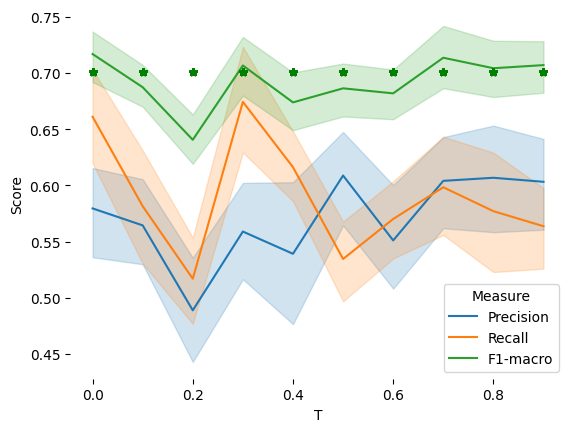

In [17]:
ax = xattds.hypothesis_testing(ssize=50)
ax.get_figure().savefig("attitudes_unimodal-eval.pdf", format="PDF", dpi=300)

The baseline (stars) struggles, especially because polarized (multimodal) items confuse it.
The hypothesis model with an explicit polarized class is more robust, achieving better or at least equal macro-F1 across thresholds.
It also shows the trade-off: high recall at low thresholds vs higher precision at stricter thresholds.

In [18]:
p, b, m = xattds.pvalue(th=0.6, ssize=50)
print(p)
print(f"{np.mean(m):.2f} compared to the baseline: {np.mean(b):.2f}")

MannwhitneyuResult(statistic=np.float64(129.5), pvalue=np.float64(0.02899784595713213))
0.71 compared to the baseline: 0.68


In [19]:
p, b, m = xattds.pvalue(th=0.5, ssize=50)
print(p)
print(f"{np.mean(m):.2f} compared to the baseline: {np.mean(b):.2f}")

MannwhitneyuResult(statistic=np.float64(231.5), pvalue=np.float64(0.807081214539811))
0.68 compared to the baseline: 0.69


In [20]:
p, b, m = xattds.pvalue(th=0.4, ssize=50)
print(p)
print(f"{np.mean(m):.2f} compared to the baseline: {np.mean(b):.2f}")

MannwhitneyuResult(statistic=np.float64(178.5), pvalue=np.float64(0.2847370705724385))
0.69 compared to the baseline: 0.68


AUC: 0.614
              precision    recall  f1-score   support

       civil       0.49      0.46      0.47        68
         k+1       0.53      0.56      0.55        71
       toxic       0.26      0.28      0.27        18

    accuracy                           0.48       157
   macro avg       0.43      0.43      0.43       157
weighted avg       0.48      0.48      0.48       157



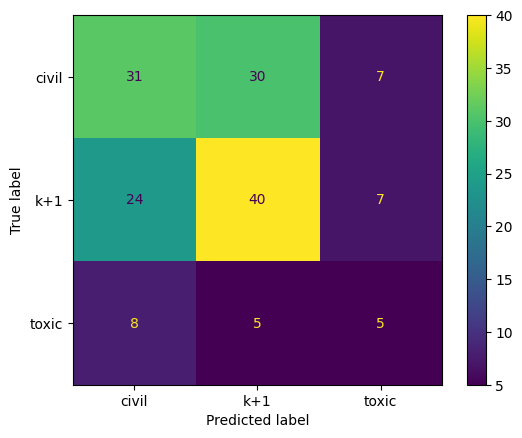

In [21]:
# 3-class assessment
th = 0.0
target = xattds.test.apply(lambda x: xattds.labeller(x.DFU, x.scores, th), 1)
prediction = xattds.models[th].predict(xattds.to_np(xattds.test.bert))
predict_probs = xattds.models[th].predict_proba(xattds.to_np(xattds.test.bert))
print(f"AUC: {roc_auc_score(target, predict_probs, average='macro', multi_class='ovr'):.3f}")
print(classification_report(target, prediction))
cm = ConfusionMatrixDisplay.from_predictions(target, prediction);
cm.figure_.savefig("attitudes-k+1.pdf", format="PDF", dpi=300)

K+1 approach shows good results, better than the baseline

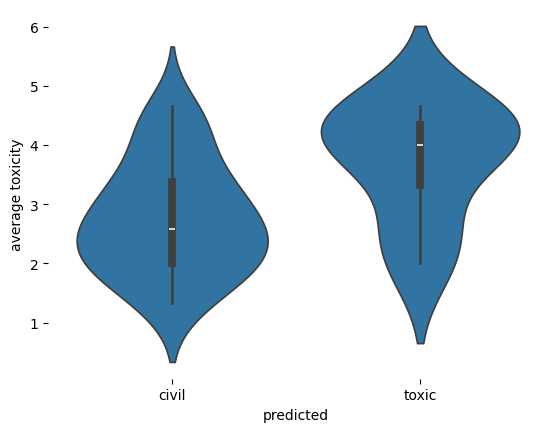

In [22]:
err1 = xattds.test[(target=="k+1")&(prediction=="civil")] # +1 said civil
err2 = xattds.test[(target=="k+1")&(prediction=="toxic")] # +1 said toxic
ax = sns.violinplot(data=pd.DataFrame({"average toxicity":(err1.scores.apply(np.mean)).to_list()+(6-err2.scores.apply(np.mean)).to_list(),
                                       "predicted": ["civil"]*err1.shape[0] + ["toxic"]*err2.shape[0]
                                       }), y="average toxicity", x="predicted");
sns.despine(left=True, bottom=True)

ax.get_figure().savefig("attitudes_violins.pdf", format="PDF", dpi=300)

# Investigating the support

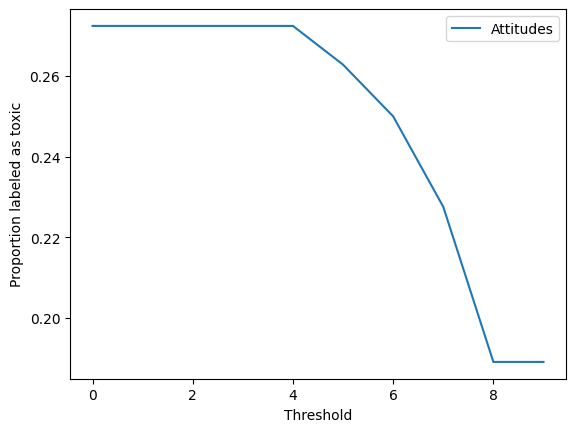

In [23]:
support_pd = pd.DataFrame()
for corpus, name in [(xattds, "Attitudes")]:
    s = []
    for th in corpus.thresholds:
        target = corpus.train.apply(lambda x: corpus.labeller(x.DFU, x.scores, th), axis=1)
        s.append((target == "toxic").sum() / corpus.train.shape[0])
    support_pd[name] = s

ax = support_pd.plot()
ax.set_xlabel("Threshold")
ax.set_ylabel("Proportion labeled as toxic")

plt.show()

Depending on how strict the threshold is, between 19% and 27% of Attitudes posts are considered toxic

# Exploratory

In [24]:
# === Dataset statistics for Attitudes only ===
name = "Attitudes"
dataset = att_train
text_col = "tweet"

print(f"{name}")
print(f"# chars (mean ± std): {dataset[text_col].apply(len).mean():.2f} ({dataset[text_col].apply(len).std():.2f})")
print(f"# instances: {dataset.shape[0]}")
print(f"# codes per instance (mean ± std): {dataset.scores.apply(len).mean():.2f} ({dataset.scores.apply(len).std():.2f})")


Attitudes
# chars (mean ± std): 133.65 (91.78)
# instances: 312
# codes per instance (mean ± std): 5.59 (0.76)


In [25]:
att_train.head()

,tweet,toyou,toany,annotatorminority,bert,annotatorpolitics,traditionalism,annotatorrace,annotatorage,annotatorgender,...,harmhatespeech,intent,lingpurism,racism,racist,scores,HIST,DFU,toxicity,target
208,I just want my fucking hair done :woman_facepa...,"[5, 3, 1, 3, 2, 2]","[4, 5, 1, 3, 4, 2]","[{}, NONE, {}, {}, Jewish, {}]","[0.25458770990371704, 0.05512981489300728, 0.1...","[-0.5, 1.0, 0.5, 0.5, -0.5, -0.5]","[5, 3, 3, 2, 4, 4]","[black, black, white, white, white, white]","[30.0, 45.0, 45.0, 35.0, 30.0, 25.0]","[woman, man, man, man, man, man]",...,"[3, 4, 3, 2, 4, 3]","[3, 3, 1, 2, 2, 2]","[5, 3, 4, 2, 3, 5]","[2, 2, 3, 3, 2, 2]","[1, 5, 1, 3, 1, 2]","[5, 3, 1, 3, 2, 2]","[0.16666666666666666, 0.3333333333333333, 0.33...",0.5,0.0,k+1
499,You seasonal ... part time .. you'll get fucke...,"[5, 5, 3, 2, 5, 4]","[5, 5, 3, 2, 5, 4]","[{}, {}, {}, none, {}, {}]","[0.23867294192314148, 0.29648762941360474, 0.2...","[-0.5, -1.0, 0.0, -0.5, -0.5, -0.5]","[4, 5, 5, 2, 5, 4]","[black, black, white, white, white, white]","[40.0, 25.0, 40.0, 50.0, 35.0, 40.0]","[woman, woman, woman, man, woman, man]",...,"[4, 5, 5, 2, 5, 4]","[5, 5, 3, 2, 5, 5]","[2, 5, 5, 5, 4, 4]","[1, 4, 1, 3, 1, 1]","[1, 3, 3, 1, 2, 1]","[5, 5, 3, 2, 5, 4]","[0.0, 0.16666666666666666, 0.16666666666666666...",0.0,0.0,civil
550,it always be those salty ass J.Cole fans tryin...,"[3, 2, 4, 1, 5, 3]","[4, 1, 4, 1, 5, 5]","[nan, {}, {}, {}, {}, Jewish]","[-0.19669391214847565, 0.1406891942024231, 0.0...","[0.0, -0.5, 0.0, 0.5, -1.0, -0.5]","[5, 3, 5, 4, 4, 4]","[black, black, other, white, white, white]","[55.0, 30.0, 55.0, 35.0, 30.0, 30.0]","[man, woman, man, woman, man, man]",...,"[5, 4, 5, 5, 5, 4]","[4, 2, 4, 1, 5, 5]","[5, 5, 5, 5, 4, 3]","[1, 1, 2, 1, 1, 2]","[2, 1, 1, 1, 1, 1]","[3, 2, 4, 1, 5, 3]","[0.16666666666666666, 0.16666666666666666, 0.3...",0.0,0.0,civil
406,"They all say these people are so low key, that...","[3, 4, 2, 3, 3]","[3, 3, 4, 3, 3]","[Black american, {}, None, {}, {}]","[0.37510836124420166, -0.007848048582673073, 0...","[-0.5, 0.5, 0.5, -0.5, -0.5]","[5, 3, 4, 5, 4]","[black, white, white, white, white]","[30.0, 35.0, 40.0, 45.0, 35.0]","[man, man, man, woman, woman]",...,"[5, 4, 3, 5, 4]","[3, 5, 1, 2, 3]","[5, 5, 4, 5, 4]","[5, 3, 2, 2, 1]","[3, 5, 2, 2, 3]","[3, 4, 2, 3, 3]","[0.0, 0.2, 0.6, 0.2, 0.0]",0.0,0.0,civil
440,"Wasniak was doing Donnie, his wife, and Julia ...","[5, 1, 2, 4, 4, 2]","[3, 2, 3, 4, 4, 2]","[nan, {}, {}, disability, {}, {}]","[-0.2718934416770935, 0.3137650191783905, 0.06...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[3, 5, 2, 5, 5, 1]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 65.0, 30.0, 30.0]","[man, man, man, woman, man, man]",...,"[3, 3, 2, 2, 5, 5]","[5, 1, 1, 4, 4, 2]","[5, 3, 5, 5, 5, 3]","[1, 1, 4, 3, 1, 1]","[1, 1, 1, 1, 1, 1]","[5, 1, 2, 4, 4, 2]","[0.16666666666666666, 0.3333333333333333, 0.0,...",1.0,0.0,k+1


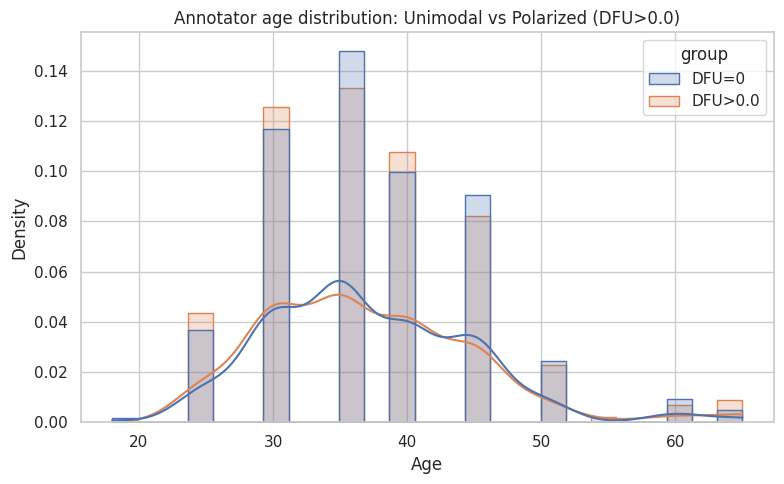

In [26]:
# Exploration by age
uni = att_train[att_train["DFU"] == 0]
pol = att_train[att_train["DFU"] > 0.0]

if len(uni):
    uni = uni.sample(n=min(100, len(uni)), random_state=42)
if len(pol):
    pol = pol.sample(n=min(100, len(pol)), random_state=42)


plot_df = pd.concat(
    [
        pd.DataFrame({"age": uni["annotatorage"].explode(), "group": "DFU=0"}),
        pd.DataFrame({"age": pol["annotatorage"].explode(), "group": "DFU>0.0"}),
    ],
    ignore_index=True,
).dropna(subset=["age"])

age_num = pd.to_numeric(plot_df["age"], errors="coerce")
is_numeric = age_num.notna().mean() > 0.8

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

if is_numeric:
    plot_df_num = plot_df.copy()
    plot_df_num["age"] = age_num
    plot_df_num = plot_df_num.dropna(subset=["age"])
    sns.histplot(
        data=plot_df_num,
        x="age",
        hue="group",
        kde=True,
        stat="density",
        common_norm=False,
        element="step",
        ax=ax,
    )
    ax.set_xlabel("Age")
    ax.set_ylabel("Density")
else:
    order = (
        plot_df["age"]
        .value_counts()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    sns.countplot(
        data=plot_df,
        x="age",
        hue="group",
        order=order,
        ax=ax,
    )
    ax.set_xlabel("Age (categories)")
    ax.set_ylabel("Count")

ax.set_title("Annotator age distribution: Unimodal vs Polarized (DFU>0.0)")

handles, labels = ax.get_legend_handles_labels()
if labels:
    ax.legend(handles=handles, labels=labels, title="Group")

plt.tight_layout()
plt.show()


In [27]:
from scipy.stats import ttest_ind

df = att_train[["annotatorage", "DFU"]].explode("annotatorage").dropna()
df["annotatorage"] = pd.to_numeric(df["annotatorage"], errors="coerce")
df = df.dropna(subset=["annotatorage"])

ages_uni = df.loc[df["DFU"] == 0, "annotatorage"]
ages_pol = df.loc[df["DFU"] > 0, "annotatorage"]

stat, p = ttest_ind(ages_uni, ages_pol, alternative="two-sided")
print(f"T-test: t={stat:.3f}, p={p:.4f}")

T-test: t=0.291, p=0.7714


At younger ages (20–30): polarized cases (orange) have a bit higher density. Suggests that younger annotators are slightly more involved in disagreement.

At mid-30s: unimodal cases (blue) dominate — agreement seems stronger among annotators in this age range.

At 40–45+: distributions overlap again, but unimodal cases show a bit more weight.

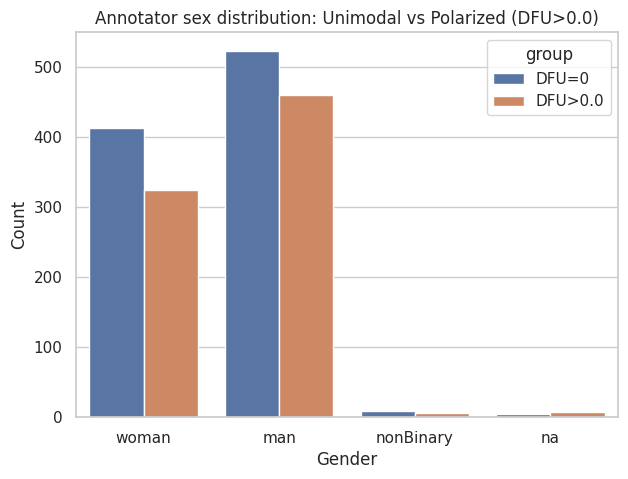

In [28]:
# Exploration by gender
uni = att_train[att_train["DFU"] == 0]
pol = att_train[att_train["DFU"] > 0.0]

s_uni = uni["annotatorgender"].explode().dropna()
s_pol = pol["annotatorgender"].explode().dropna()

plot_df = pd.concat(
    [
        pd.DataFrame({"sex": s_uni, "group": "DFU=0"}),
        pd.DataFrame({"sex": s_pol, "group": "DFU>0.0"}),
    ],
    ignore_index=True,
)

sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.countplot(data=plot_df, x="sex", hue="group")
plt.title("Annotator sex distribution: Unimodal vs Polarized (DFU>0.0)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


In [29]:
from scipy.stats import chi2_contingency

df = att_train[["annotatorgender", "DFU"]].explode("annotatorgender")

contingency = pd.crosstab(df["annotatorgender"], df["DFU"] > 0)

print("Contingency table (rows=Gender, cols=DFU>0):")
print(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)

print("\nChi-square test results:")
print(f"χ² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")

print("\nExpected counts under independence:")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))


Contingency table (rows=Gender, cols=DFU>0):
DFU              False  True 
annotatorgender              
man                523    459
na                   4      8
nonBinary            9      6
woman              412    324

Chi-square test results:
χ² = 3.587, df = 3, p-value = 0.3097

Expected counts under independence:
DFU                   False       True 
annotatorgender                        
man              533.487679  448.512321
na                 6.519198    5.480802
nonBinary          8.148997    6.851003
woman            399.844126  336.155874


Since the p-value is 0.301 we cannot reject the null hypothesis

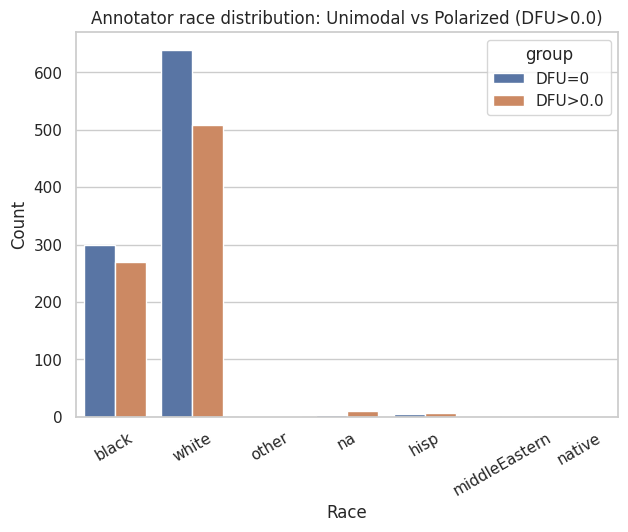

In [30]:
# Race exploration
s_uni = uni["annotatorrace"].explode().dropna()
s_pol = pol["annotatorrace"].explode().dropna()

plot_df = pd.concat(
    [
        pd.DataFrame({"race": s_uni, "group": "DFU=0"}),
        pd.DataFrame({"race": s_pol, "group": "DFU>0.0"}),
    ],
    ignore_index=True,
)

sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.countplot(data=plot_df, x="race", hue="group")
plt.title("Annotator race distribution: Unimodal vs Polarized (DFU>0.0)")
plt.xlabel("Race")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


This graph shows that white annotators dominate both unimodal (DFU=0) and polarized (DFU>0) cases, but their relative drop is larger in polarized ones, indicating they contribute more to disagreements.
Black annotators remain more balanced across the two groups, while other racial categories have very small counts, making their patterns unreliable.

In [31]:
df = att_train[["annotatorrace", "DFU"]].explode("annotatorrace")

contingency = pd.crosstab(df["annotatorrace"], df["DFU"] > 0)

print("Contingency table (rows=Race, cols=DFU>0):")
print(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)

print("\nChi-square test results:")
print(f"χ² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")

print("\nExpected counts under independence:")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))


Contingency table (rows=Race, cols=DFU>0):
DFU            False  True 
annotatorrace              
black            299    269
hisp               5      6
middleEastern      0      1
na                 4     10
native             0      1
other              2      2
white            638    508

Chi-square test results:
χ² = 7.987, df = 6, p-value = 0.2390

Expected counts under independence:
DFU                 False       True 
annotatorrace                        
black          308.575358  259.424642
hisp             5.975931    5.024069
middleEastern    0.543266    0.456734
na               7.605731    6.394269
native           0.543266    0.456734
other            2.173066    1.826934
white          622.583381  523.416619


Since the p-value is 0.24 we cannot reject the null hypothesis

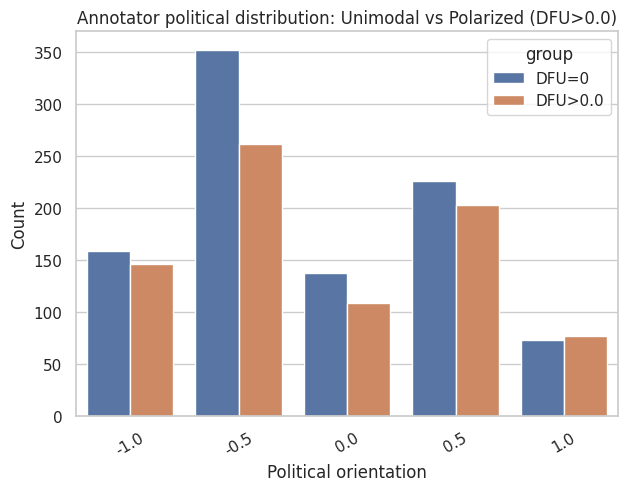

In [32]:
# Politics exploration
s_uni_pol = uni["annotatorpolitics"].explode().dropna()
s_pol_pol = pol["annotatorpolitics"].explode().dropna()

plot_df_pol = pd.concat(
    [
        pd.DataFrame({"politics": s_uni_pol, "group": "DFU=0"}),
        pd.DataFrame({"politics": s_pol_pol, "group": "DFU>0.0"}),
    ],
    ignore_index=True,
)

sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.countplot(data=plot_df_pol, x="politics", hue="group")
plt.title("Annotator political distribution: Unimodal vs Polarized (DFU>0.0)")
plt.xlabel("Political orientation")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


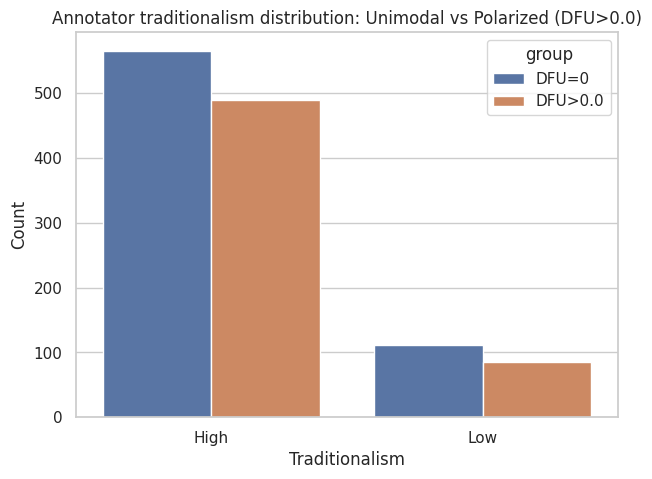

In [33]:
s_uni_trad = uni["traditionalism"].explode().dropna()
s_pol_trad = pol["traditionalism"].explode().dropna()

def recode_trad(x):
    if x in [1, 2]:
        return "Low"
    elif x in [4, 5]:
        return "High"
    else:
        return None

s_uni_trad = s_uni_trad.map(recode_trad).dropna()
s_pol_trad = s_pol_trad.map(recode_trad).dropna()

plot_df_trad = pd.concat(
    [
        pd.DataFrame({"traditionalism": s_uni_trad, "group": "DFU=0"}),
        pd.DataFrame({"traditionalism": s_pol_trad, "group": "DFU>0.0"}),
    ],
    ignore_index=True,
)

sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.countplot(data=plot_df_trad, x="traditionalism", hue="group")
plt.title("Annotator traditionalism distribution: Unimodal vs Polarized (DFU>0.0)")
plt.xlabel("Traditionalism")
plt.ylabel("Count")
plt.show()


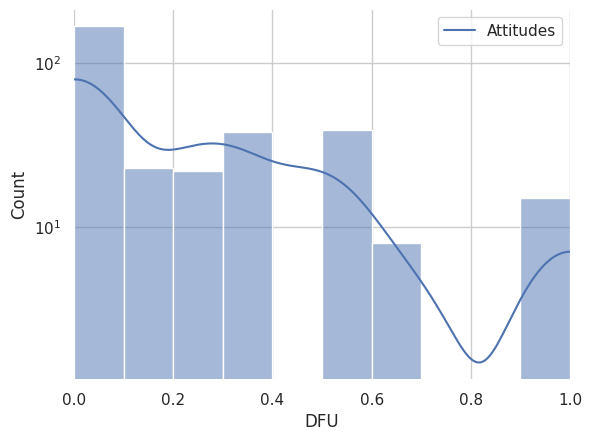

In [34]:
fig, ax = plt.subplots()
labels = []
for name, a in [("Attitudes", att_train)]:
    sns.histplot(a.DFU, ax=ax, kde=True, bins=10, legend=True)
    ax.set_yscale('log')
    ax.set_xlabel("DFU")
    labels.append(name)
plt.legend(labels=labels)
ax.set_xlim([0, 1])
sns.despine(bottom=True, left=True)
ax.get_figure().savefig("dfu_hists.pdf", format="PDF", dpi=300)

Most tweets in the Attitudes dataset have low DFU values (high annotator agreement), with fewer cases showing strong polarization at DFU ≈ 1 and very few in-between.

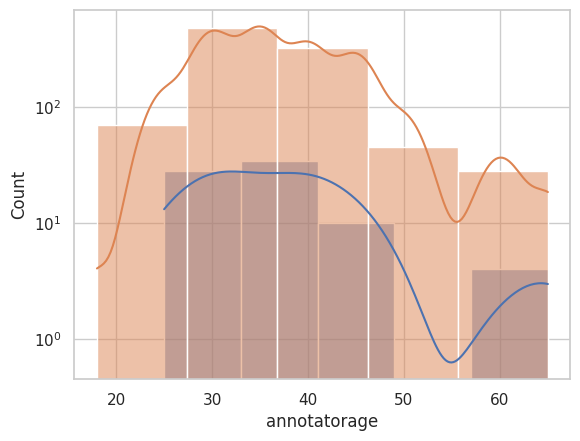

In [35]:
#Compare ages
fig, ax = plt.subplots()
sns.histplot(att_train[att_train.DFU>att_train.DFU.quantile(0.95)].annotatorage.explode(), ax=ax, kde=True, bins=5)
sns.histplot(att_train[att_train.DFU==0].annotatorage.explode(), ax=ax, kde=True, bins=5)
ax.set_xlabel("annotatorage")
ax.set_yscale('log')

**Unimodal agreement** is concentrated among mid-aged annotators (30s-40s), while the most polarized cases involve a broader mix of younger and older annotators (20 to 50+), suggesting that age diversity contributes to disagreement.

In [36]:
# xm_train[['comment', 'toxicity', 'toxicity_score', 'gender', 'age_group', 'education', 'HIST', 'DFU', 'target', 'scores']].to_csv("xm_train.csv", index=False)
# cctk_train[['text', 'scores', 'country', 'HIST', 'DFU']].to_csv("cctk_train.csv", index=False)
att_train[['tweet', 'toyou', 'toany', 'annotatorminority', 'annotatorpolitics', 'traditionalism', 'annotatorrace', 'annotatorage', 'annotatorgender', 'freespeech', 'harmhatespeech', 'intent', 'lingpurism', 'racism', 'racist', 'scores', 'HIST', 'DFU', 'toxicity', 'target']].to_csv("att_train.csv", index=False)

# A posteriori unimodal: Attitudes

In [37]:
# RECALL TO UPLOAD THE DATA
attitudes = pd.read_pickle("attitudes_embedded.csv")
scale = list(range(1,6))
attitudes["scores"] = attitudes.toyou
attitudes["HIST"] = attitudes.scores.apply(lambda x: pdf(x, scale))
attitudes["DFU"] = attitudes.HIST.apply(dfu)


## Focus on gender

We keep here the polarized texts where both men and women are present, have enough votes

In [38]:
high_pol = attitudes.DFU>0 # polarized
big_size = attitudes.annotatorGender.apply(len)>=6 # enough votes
supported = attitudes.annotatorGender.apply(lambda x: (Counter(x)["woman"]>1) and (Counter(x)["man"]>1)) # both groups present
shortlist = attitudes[high_pol&big_size&supported]
shortlist.shape

(135, 19)

In [39]:
dfu_gender = lambda row, gender="man", toxcol="toyou": dfu(pdf([row[toxcol][i] for i,g in enumerate(row.annotatorGender) if g==gender], scale))
x_gender = shortlist[(shortlist.apply(lambda r: dfu_gender(r, "man"), 1)==0)&(shortlist.apply(lambda r: dfu_gender(r, "woman"), 1)==0)]
x_gender

,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
93,Bitches be too mad bitch get some money and mo...,"[5, 5, 2, 4, 4, 1]","[5, 5, 3, 4, 4, 2]","[{}, {}, none, {}, {}, {}]","[0.2549588084220886, -0.04279607906937599, 0.2...","[-0.5, -1.0, -0.5, 0.5, -0.5, -1.0]","[4, 5, 2, 3, 5, 4]","[black, black, white, white, white, white]","[40.0, 25.0, 50.0, 35.0, 35.0, 25.0]","[woman, woman, man, woman, woman, man]","[1, 3, 1, 1, 1, 1]","[4, 5, 2, 5, 5, 4]","[5, 5, 3, 4, 4, 1]","[2, 5, 5, 5, 4, 5]","[1, 4, 3, 3, 1, 1]","[2, 3, 2, 3, 3, 1]","[5, 5, 2, 4, 4, 1]","[0.16666666666666666, 0.16666666666666666, 0.0...",0.500000
289,Keep in mind that sexual contact of any kind w...,"[2, 5, 5, 3, 5, 1]","[4, 5, 5, 5, 5, 2]","[NONE, immigrant, black,, {}, {}, bisexual, Ve...","[-0.23865552246570587, -0.010829821228981018, ...","[1.0, 0.0, 0.5, 0.5, -0.5, -1.0]","[3, 3, 5, 3, 3, 5]","[black, black, white, white, white, white]","[45.0, 35.0, 35.0, 45.0, 40.0, 35.0]","[man, woman, woman, man, woman, man]","[5, 1, 1, 4, 1, 1]","[4, 4, 4, 3, 5, 5]","[3, 5, 5, 3, 5, 1]","[3, 4, 5, 4, 5, 5]","[5, 1, 2, 3, 1, 5]","[4, 1, 3, 1, 1, 1]","[2, 5, 5, 3, 5, 1]","[0.16666666666666666, 0.16666666666666666, 0.1...",0.333333
318,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,"[4, 4, 3, 2, 2, 2]","[4, 4, 2, 3, 2, 3]","[nan, {}, {}, {}, {}, {}]","[-0.21125884354114532, 0.3873864412307739, -0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -0.5]","[3, 5, 2, 4, 4, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 35.0, 35.0, 45.0]","[man, man, man, woman, woman, woman]","[1, 1, 5, 1, 2, 1]","[3, 3, 2, 3, 3, 4]","[5, 4, 3, 2, 3, 2]","[5, 3, 5, 5, 4, 4]","[1, 1, 4, 1, 2, 1]","[1, 1, 1, 1, 1, 1]","[4, 4, 3, 2, 2, 2]","[0.0, 0.5, 0.16666666666666666, 0.333333333333...",0.333333
369,Sometimes I'll cut a jawn off just for being s...,"[4, 1, 4, 3, 2, 2]","[3, 1, 5, 4, 2, 3]","[nan, {}, {}, {}, {}, {}]","[0.22918452322483063, 0.273483544588089, -0.15...","[-0.5, -0.5, 0.5, 0.0, -0.5, -1.0]","[3, 5, 5, 5, 4, 1]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 30.0, 35.0, 30.0]","[man, woman, man, man, woman, man]","[1, 1, 1, 2, 2, 1]","[3, 3, 5, 4, 3, 5]","[5, 1, 5, 3, 4, 5]","[5, 5, 5, 4, 4, 3]","[1, 2, 1, 3, 2, 1]","[1, 1, 1, 3, 1, 1]","[4, 1, 4, 3, 2, 2]","[0.16666666666666666, 0.3333333333333333, 0.16...",0.500000
516,boy i've never been in a fight before but i fr...,"[4, 3, 3, 1, 3, 1]","[3, 3, 3, 2, 3, 3]","[nan, none, {}, {}, {}, bisexual]","[-0.011250785551965237, 0.03692465275526047, 0...","[-0.5, 0.0, 0.5, 0.5, -0.5, -0.5]","[3, 3, 5, 4, 3, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 30.0, 40.0]","[man, man, man, woman, man, woman]","[1, 3, 1, 1, 1, 1]","[3, 2, 5, 3, 5, 5]","[2, 3, 5, 1, 2, 4]","[5, 5, 5, 5, 1, 5]","[1, 3, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[4, 3, 3, 1, 3, 1]","[0.3333333333333333, 0.0, 0.5, 0.1666666666666...",0.666667
556,let me tell you hey fuck you who ever made thi...,"[3, 2, 5, 5, 5, 5]","[4, 2, 4, 5, 5, 5]","[{}, {}, {}, None, immigrant, {}]","[-0.19164827466011047, 0.24510705471038818, 0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -1.0]","[3, 3, 3, 4, 5, 4]","[black, black, white, white, white, white]","[35.0, 30.0, 35.0, 40.0, 40.0, 30.0]","[woman, woman, man, man, man, man]","[1, 1, 1, 2, 5, 3]","[4, 4, 4, 3, 5, 5]","[3, 2, 5, 4, 5, 5]","[3, 5, 5, 4, 5, 4]","[1, 1, 3, 2, 2, 1]","[3, 1, 5, 4, 5, 5]","[3, 2, 5, 5, 5, 5]","[0.0, 0.16666666666666666, 0.16666666666666666...",0.250000


In [40]:
x_gender.shape

(6, 19)

In only 6 tweets women agree with themselvs and men with themselves

In [41]:
x_gender.to_excel('aposteriori_unimodal_attitudes.gender.xlsx')

## Focus on Race

In [42]:
race_idx = {
    "black": 1,
    "white": 0,
    "hisp": -1,
    "na": -1,
    "other": -1,
    "native": -1,
    "middleEastern": -1
}

big_size = attitudes.annotatorRace.apply(len) == 6  # exactly 6 annotators
supported = attitudes.annotatorRace.apply(
    lambda x: (Counter(x)["black"] > 1) and (Counter(x)["white"] > 1)
)

shortlist = attitudes[high_pol & big_size & supported]
shortlist.shape


(181, 19)

In [43]:
#Extract text where men agree themselves and the same applies for women
dfu_condition = lambda row, key="black", toxcol="toyou", key_col='annotatorRace': dfu(pdf([row[toxcol][i] for i,g in enumerate(row[key_col]) if g==key], scale))
x_race = shortlist[(shortlist.apply(lambda r: dfu_condition(r, key="black", key_col='annotatorRace'), 1)==0)&(shortlist.apply(lambda r: dfu_condition(r, "white", key_col='annotatorRace'), 1)==0)]
x_race

,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
309,My mom so aggravating every time I like a car ...,"[4, 4, 2, 2, 1, 2]","[4, 5, 2, 2, 2, 2]","[{}, {}, {}, {}, {}, {}]","[0.09306392818689346, -0.14795063436031342, 0....","[-0.5, -1.0, 0.0, 0.5, -0.5, -0.5]","[4, 5, 5, 3, 5, 5]","[black, black, white, white, white, white]","[40.0, 25.0, 40.0, 35.0, 35.0, 35.0]","[woman, woman, woman, woman, woman, woman]","[1, 3, 1, 1, 1, 1]","[4, 5, 5, 5, 5, 5]","[4, 4, 2, 2, 2, 3]","[2, 5, 5, 5, 4, 4]","[1, 4, 1, 3, 1, 1]","[1, 3, 1, 1, 1, 1]","[4, 4, 2, 2, 1, 2]","[0.16666666666666666, 0.5, 0.0, 0.333333333333...",0.666667
318,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,"[4, 4, 3, 2, 2, 2]","[4, 4, 2, 3, 2, 3]","[nan, {}, {}, {}, {}, {}]","[-0.21125884354114532, 0.3873864412307739, -0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -0.5]","[3, 5, 2, 4, 4, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 35.0, 35.0, 45.0]","[man, man, man, woman, woman, woman]","[1, 1, 5, 1, 2, 1]","[3, 3, 2, 3, 3, 4]","[5, 4, 3, 2, 3, 2]","[5, 3, 5, 5, 4, 4]","[1, 1, 4, 1, 2, 1]","[1, 1, 1, 1, 1, 1]","[4, 4, 3, 2, 2, 2]","[0.0, 0.5, 0.16666666666666666, 0.333333333333...",0.333333
342,Reminds me about a guy on 4chan who genuinely ...,"[4, 3, 4, 1, 1, 1]","[4, 3, 4, 1, 2, 2]","[{}, {}, {}, {}, Veteran, {}]","[-0.04991382732987404, -0.11697617918252945, -...","[-1.0, 0.0, 0.5, 0.0, -1.0, -0.5]","[5, 4, 5, 5, 5, 5]","[black, black, hisp, white, white, white]","[25.0, 35.0, 30.0, 40.0, 35.0, 35.0]","[woman, man, man, woman, man, woman]","[3, 1, 3, 1, 1, 1]","[5, 4, 5, 5, 5, 5]","[3, 2, 2, 1, 1, 1]","[5, 4, 4, 5, 5, 4]","[4, 1, 1, 1, 5, 1]","[5, 3, 4, 1, 1, 1]","[4, 3, 4, 1, 1, 1]","[0.5, 0.0, 0.16666666666666666, 0.333333333333...",0.333333
357,Sick to death of either seein nobs or ur minge...,"[5, 5, 3, 2, 2, 3]","[5, 5, 3, 3, 2, 3]","[{}, {}, none, {}, {}, {}]","[-0.042324356734752655, 0.20226505398750305, -...","[-0.5, 0.0, -0.5, 0.0, -0.5, -1.0]","[4, 5, 2, 2, 2, 4]","[black, black, white, white, white, white]","[40.0, 45.0, 50.0, 35.0, 40.0, 25.0]","[woman, man, man, man, man, man]","[1, 1, 1, 3, 1, 1]","[4, 5, 2, 2, 4, 4]","[4, 5, 2, 2, 3, 3]","[2, 4, 5, 3, 5, 5]","[1, 1, 3, 1, 1, 1]","[1, 5, 1, 1, 1, 1]","[5, 5, 3, 2, 2, 3]","[0.0, 0.3333333333333333, 0.3333333333333333, ...",1.000000
364,So can we just stop saying there is no racism ...,"[5, 4, 2, 5, 5, 4]","[5, 4, 4, 5, 5, 5]","[Black american, {}, {}, {}, {}, {}]","[-0.12828494608402252, 0.061020202934741974, 0...","[-0.5, -0.5, 0.0, 0.5, -1.0, -1.0]","[5, 3, 5, 4, 4, 5]","[black, black, other, white, white, white]","[30.0, 30.0, 55.0, 35.0, 30.0, 45.0]","[man, woman, man, woman, man, woman]","[1, 1, 2, 1, 3, 1]","[5, 4, 5, 5, 5, 5]","[5, 4, 2, 5, 5, 3]","[5, 5, 5, 5, 4, 5]","[5, 1, 2, 1, 1, 1]","[5, 2, 2, 5, 5, 3]","[5, 4, 2, 5, 5, 4]","[0.0, 0.16666666666666666, 0.0, 0.333333333333...",0.333333
423,This raghead colleague is such a traitor!,"[3, 3, 5, 5, 5, 5]","[3, 3, 3, 5, 2, 5]","[Black american, {}, {}, {}, {}, nan]","[0.04868575558066368, 0.5501320958137512, -0.1...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[5, 3, 3, 4, 2, 5]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 35.0, 45.0]","[man, woman, man, woman, woman, woman]","[1, 1, 1, 1, 1, 1]","[5, 4, 4, 5, 5, 5]","[3, 4, 4, 5, 5, 5]","[5, 5, 5, 5, 4, 3]","[5, 1, 3, 1, 1, 1]","[1, 4, 4, 4, 5, 5]","[3, 3, 5, 5, 5, 5]","[0.0, 0.0, 0.3333333333333333, 0.0, 0.66666666...",0.500000
546,"imagine being such absolute scum, I want those...","[5, 5, 4, 1, 5, 5]","[5, 5, 5, 2, 5, 5]","[{}, {}, nan, {}, {}, {}]","[0.3449878394603729, 0.44626960158348083, 0.12...","[-1.0, 0.0, 1.0, 0.5, -0.5, -0.5]","[5, 4, 3, 5, 5, 3]","[black, black, white, hisp, white, white]","[25.0, 35.0, 35.0, 30.0, 35.0, 45.0]","[woman, man, man, man, woman, woman]","[3, 1, 5, 3, 1, 2]","[5, 4, 1, 5, 5, 3]

In [44]:
x_race.shape

(9, 19)

In [45]:
 x_race.to_excel('aposteriori_unimodal_attitudes.race.xlsx')

In [46]:
def extract_examples_with_means(df, dim_col, toxcol="toyou", threshold=3, drop_na=False):
    examples = []
    all_groups = set()

    for _, row in df.iterrows():
        entry = {"tweet": row["tweet"]}
        for grp in set(row[dim_col]):
            scores = [row[toxcol][i] for i, g in enumerate(row[dim_col]) if g == grp]

            if not scores:
                label, mean = "NA", None
            else:
                labels = ["toxic" if s >= threshold else "civil" for s in scores]
                counts = Counter(labels)
                if len(counts) == 2 and counts["toxic"] == counts["civil"]:
                    label = "tie"
                else:
                    label = max(counts, key=counts.get)
                mean = np.mean(scores)

            entry[f"{grp}_label"] = label
            entry[f"{grp}_mean"] = mean
            all_groups.add(grp)
        examples.append(entry)

    result = pd.DataFrame(examples)
    if drop_na:
      result=result.dropna(axis=1, how='any')
    return result

In [47]:
df_race = extract_examples_with_means(x_race, "annotatorRace", "toyou", threshold=3,drop_na=True)
print(df_race)


                                               tweet black_label  black_mean  \
0  My mom so aggravating every time I like a car ...       toxic         4.0   
1  No clout. I WONT GIVE A RAT NO FAME I WON'T GI...       toxic         4.0   
2  Reminds me about a guy on 4chan who genuinely ...       toxic         3.5   
3  Sick to death of either seein nobs or ur minge...       toxic         5.0   
4  So can we just stop saying there is no racism ...       toxic         4.5   
5          This raghead colleague is such a traitor!       toxic         3.0   
6  imagine being such absolute scum, I want those...       toxic         5.0   
7  let me tell you hey fuck you who ever made thi...         tie         2.5   
8  you've got to be fucking joking, my room has l...       toxic         3.0   

  white_label  white_mean  
0       civil    1.750000  
1       civil    2.250000  
2       civil    1.000000  
3         tie    2.500000  
4       toxic    4.666667  
5       toxic    5.000000  
6  

In [48]:
def filter_different_labels(df):
    drop_indices = []
    for idx, row in df.iterrows():
        if row["white_label"] == row["black_label"]:
            print(f"White mean: {row['white_mean']}, Black mean: {row['black_mean']}")
            drop_indices.append(idx)
    return df.drop(drop_indices)


In [49]:
df_race=filter_different_labels(df_race)


White mean: 4.666666666666667, Black mean: 4.5
White mean: 5.0, Black mean: 3.0
White mean: 4.666666666666667, Black mean: 5.0


# **Focus on Age**

AU (Association Uncertainty) is the metric you maximize to choose the age threshold that best explains polarization (DFU>0 vs DFU=0).


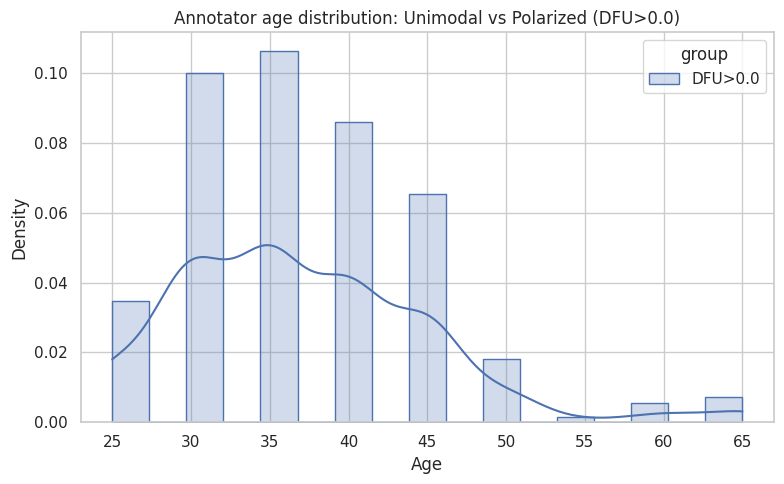

In [50]:
# Exploration by age
pol = att_train[att_train["DFU"] > 0.0]

if len(pol):
    pol = pol.sample(n=min(100, len(pol)), random_state=42)


plot_df = pd.concat(
    [
        pd.DataFrame({"age": pol["annotatorage"].explode(), "group": "DFU>0.0"}),
    ],
    ignore_index=True,
).dropna(subset=["age"])

age_num = pd.to_numeric(plot_df["age"], errors="coerce")
is_numeric = age_num.notna().mean() > 0.8

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

if is_numeric:
    plot_df_num = plot_df.copy()
    plot_df_num["age"] = age_num
    plot_df_num = plot_df_num.dropna(subset=["age"])
    sns.histplot(
        data=plot_df_num,
        x="age",
        hue="group",
        kde=True,
        stat="density",
        common_norm=False,
        element="step",
        ax=ax,
    )
    ax.set_xlabel("Age")
    ax.set_ylabel("Density")
else:
    order = (
        plot_df["age"]
        .value_counts()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    sns.countplot(
        data=plot_df,
        x="age",
        hue="group",
        order=order,
        ax=ax,
    )
    ax.set_xlabel("Age (categories)")
    ax.set_ylabel("Count")

ax.set_title("Annotator age distribution: Unimodal vs Polarized (DFU>0.0)")

handles, labels = ax.get_legend_handles_labels()
if labels:
    ax.legend(handles=handles, labels=labels, title="Group")

plt.tight_layout()
plt.show()


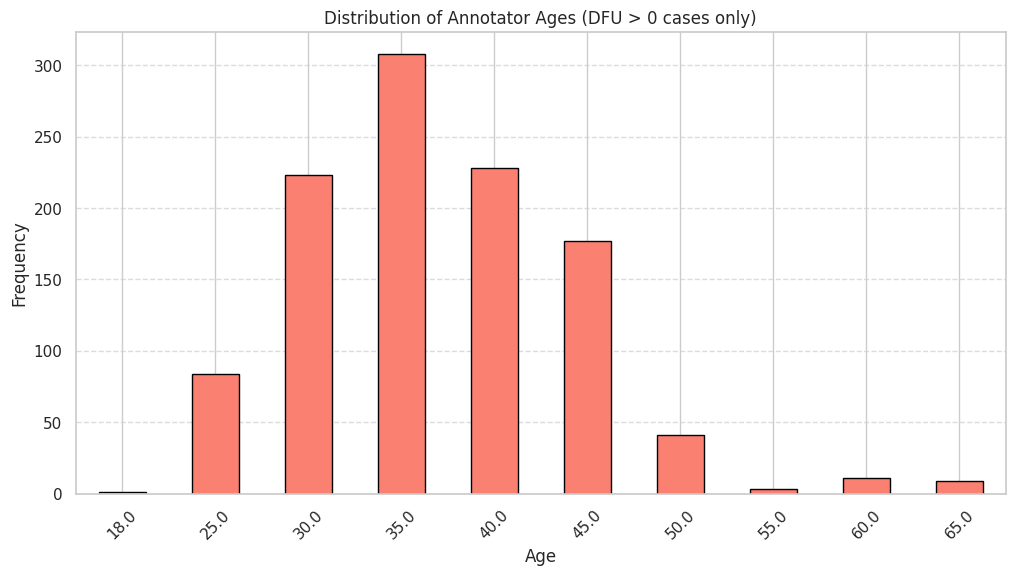

annotatorAge
18.0      1
25.0     84
30.0    223
35.0    308
40.0    228
45.0    177
50.0     41
55.0      3
60.0     11
65.0      9
Name: count, dtype: int64


In [51]:
polarized = shortlist[shortlist["DFU"] > 0]

# Explode ages to annotation-level
df_long = polarized.explode(["annotatorAge"]).dropna(subset=["annotatorAge"])
df_long["annotatorAge"] = pd.to_numeric(df_long["annotatorAge"], errors="coerce")
df_long = df_long.dropna(subset=["annotatorAge"])

# Count frequencies
age_counts = df_long["annotatorAge"].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12,6))
age_counts.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Distribution of Annotator Ages (DFU > 0 cases only)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Show top 20 most frequent ages
print(age_counts.head(20))


**Max AU computation**

In [52]:
def compute_AU_for_row_threshold(row, theta, toxcol="toyou", age_col="annotatorAge"):
    ages = row[age_col]
    scores = row[toxcol]

    if ages is None or scores is None or len(ages) <= 2:
        return None

    A1 = [s for s, g in zip(scores, ages) if g > theta]
    A2 = [s for s, g in zip(scores, ages) if g <= theta]

    if len(A1) <= 1 or len(A2) <= 1:
        return None

    dfu_A  = dfu(pdf(scores, scale))
    dfu_A1 = dfu(pdf(A1, scale))
    dfu_A2 = dfu(pdf(A2, scale))

    return dfu_A - max(dfu_A1, dfu_A2)


def aggregate_AU_by_threshold(df, toxcol="toyou", age_col="annotatorAge"):
    all_ages = sorted(set(a for ages in df[age_col].dropna() for a in ages if ages is not None))
    results = []

    for theta in all_ages:
        AU_values = df.apply(lambda r: compute_AU_for_row_threshold(r, theta, toxcol, age_col), axis=1)
        AU_values = AU_values.dropna().tolist()
        if not AU_values:
            continue

        results.append({
            "theta": theta,
            "sum_AU": sum(AU_values),
            "mean_AU": np.mean(AU_values),
            "count": len(AU_values)
        })

    return pd.DataFrame(results).sort_values("sum_AU", ascending=False)


# === Run aggregation ===
df_age_global = aggregate_AU_by_threshold(shortlist)
print(df_age_global)

best_theta = df_age_global.iloc[0]["theta"]
best_sumAU = df_age_global.iloc[0]["sum_AU"]
print(f"Best threshold across dataset: {best_theta}, with ΣAU = {best_sumAU:.3f}")


   theta     sum_AU   mean_AU  count
6   55.0  -0.500000 -0.500000      1
5   50.0  -0.500000 -0.250000      2
4   45.0  -1.500000 -0.250000      6
0   25.0  -3.883333 -0.431481      9
3   40.0 -18.500000 -0.272059     68
1   30.0 -21.150000 -0.235000     90
2   35.0 -39.200000 -0.272222    144
Best threshold across dataset: 55.0, with ΣAU = -0.500


In [53]:
def get_examples_for_theta(df, theta, toxcol="toyou", age_col="annotatorAge", n=3):
    shown = 0
    for idx, row in df.iterrows():
        ages = row[age_col]
        scores = row[toxcol]

        if ages is None or scores is None or len(ages) <= 2:
            continue

        A1 = [s for s, g in zip(scores, ages) if g > theta]
        A2 = [s for s, g in zip(scores, ages) if g <= theta]

        if len(A1) <= 1 or len(A2) <= 1:
            continue

        dfu_A  = dfu(pdf(scores, scale))
        dfu_A1 = dfu(pdf(A1, scale))
        dfu_A2 = dfu(pdf(A2, scale))
        AU_val = dfu_A - max(dfu_A1, dfu_A2)

        print(f"\n=== Example {shown+1} at θ={theta} (index {idx}) ===")
        print(f"Tweet/text: {row.get('tweet', 'N/A')}")
        print(f"Ages: {ages}")
        print(f"Scores: {scores}")
        print(f"DFU(all)={dfu_A:.3f}, DFU(> {theta})={dfu_A1:.3f}, DFU(≤ {theta})={dfu_A2:.3f}, AU={AU_val:.3f}")

        shown += 1
        if shown >= n:
            break


for theta in [55, 50]:
    get_examples_for_theta(shortlist, theta, n=3)



=== Example 1 at θ=55 (index 77) ===
Tweet/text: And anybody that know me personally know i actually be tryna make this shit work with her,but shit just sad.
Ages: [30.0, 30.0, 65.0, 60.0, 30.0, 30.0]
Scores: [3, 1, 3, 1, 1, 1]
DFU(all)=0.500, DFU(> 55)=1.000, DFU(≤ 55)=0.333, AU=-0.500

=== Example 1 at θ=50 (index 77) ===
Tweet/text: And anybody that know me personally know i actually be tryna make this shit work with her,but shit just sad.
Ages: [30.0, 30.0, 65.0, 60.0, 30.0, 30.0]
Scores: [3, 1, 3, 1, 1, 1]
DFU(all)=0.500, DFU(> 50)=1.000, DFU(≤ 50)=0.333, AU=-0.500

=== Example 2 at θ=50 (index 387) ===
Tweet/text: The bloody hell Trump, why use 59 missiles? Even though they did launch a chemical attack on us, 59 is a bit overkill. also #russiaismad
Ages: [55.0, 30.0, 40.0, 35.0, 45.0, 65.0]
Scores: [2, 1, 1, 1, 4, 2]
DFU(all)=0.333, DFU(> 50)=0.000, DFU(≤ 50)=0.333, AU=0.000


**A>Θ AU computation**

In [54]:
def compute_AU_for_row_threshold_one_sided(row, theta, toxcol="toyou", age_col="annotatorAge"):
    ages = row[age_col]
    scores = row[toxcol]

    if ages is None or scores is None or len(ages) <= 2:
        return None

    A1 = [s for s, g in zip(scores, ages) if g > theta]

    if len(A1) <= 1:
        return None

    dfu_A  = dfu(pdf(scores, scale))
    dfu_A1 = dfu(pdf(A1, scale))

    return dfu_A - dfu_A1


def aggregate_AU_by_threshold_one_sided(df, toxcol="toyou", age_col="annotatorAge"):
    all_ages = sorted(set(a for ages in df[age_col].dropna() for a in ages if ages is not None))
    results = []

    for theta in all_ages:
        AU_values = df.apply(lambda r: compute_AU_for_row_threshold_one_sided(r, theta, toxcol, age_col), axis=1)
        AU_values = AU_values.dropna().tolist()
        if not AU_values:
            continue

        results.append({
            "theta": theta,
            "sum_AU": sum(AU_values),
            "mean_AU": np.mean(AU_values),
            "count": len(AU_values)
        })

    return pd.DataFrame(results).sort_values("sum_AU", ascending=False)

df_age_global_one_sided = aggregate_AU_by_threshold_one_sided(shortlist)
print(df_age_global_one_sided)

best_theta = df_age_global_one_sided.iloc[0]["theta"]
best_sumAU = df_age_global_one_sided.iloc[0]["sum_AU"]
print(f"Best one-sided threshold across dataset: {best_theta}, with ΣAU = {best_sumAU:.3f}")


   theta    sum_AU   mean_AU  count
1   25.0  1.250000  0.006906    181
0   18.0 -0.166667 -0.000921    181
6   50.0 -0.166667 -0.083333      2
7   55.0 -0.500000 -0.500000      1
5   45.0 -0.666667 -0.111111      6
2   30.0 -1.866667 -0.010370    180
3   35.0 -3.683333 -0.024074    153
4   40.0 -7.000000 -0.102941     68
Best one-sided threshold across dataset: 25.0, with ΣAU = 1.250


**A<Θ AU computation**

In [55]:
def compute_AU_for_row_threshold_one_sided_younger(row, theta, toxcol="toyou", age_col="annotatorAge"):
    ages = row[age_col]
    scores = row[toxcol]

    if ages is None or scores is None or len(ages) <= 2:
        return None

    A2 = [s for s, g in zip(scores, ages) if g < theta]

    if len(A2) <= 1:
        return None

    dfu_A  = dfu(pdf(scores, scale))
    dfu_A2 = dfu(pdf(A2, scale))

    return dfu_A - dfu_A2


def aggregate_AU_by_threshold_one_sided_younger(df, toxcol="toyou", age_col="annotatorAge"):
    all_ages = sorted(set(a for ages in df[age_col].dropna() for a in ages if ages is not None))
    results = []

    for theta in all_ages:
        AU_values = df.apply(lambda r: compute_AU_for_row_threshold_one_sided_younger(r, theta, toxcol, age_col), axis=1)
        AU_values = AU_values.dropna().tolist()
        if not AU_values:
            continue

        results.append({
            "theta": theta,
            "sum_AU": sum(AU_values),
            "mean_AU": np.mean(AU_values),
            "count": len(AU_values)
        })

    return pd.DataFrame(results).sort_values("sum_AU", ascending=False)


# === Run aggregation for younger group ===
df_age_global_one_sided_young = aggregate_AU_by_threshold_one_sided_younger(shortlist)
print(df_age_global_one_sided_young)

best_theta = df_age_global_one_sided_young.iloc[0]["theta"]
best_sumAU = df_age_global_one_sided_young.iloc[0]["sum_AU"]
print(f"Best one-sided threshold across dataset: {best_theta}, with ΣAU = {best_sumAU:.3f}")


   theta    sum_AU   mean_AU  count
3   45.0  6.333333  0.034991    181
1   35.0  3.966667  0.043590     91
2   40.0  1.516667  0.008818    172
4   65.0  1.116667  0.006169    181
6   55.0  0.583333  0.003223    181
7   60.0  0.250000  0.001381    181
0   30.0 -1.050000 -0.116667      9
5   50.0 -1.783333 -0.009853    181
Best one-sided threshold across dataset: 45.0, with ΣAU = 6.333


**Max-based AU** → Best threshold = 55, but with only 1 valid tweet and ΣAU < 0.
➝ Strict condition (both groups unimodal) rarely satisfied → age does not explain polarization.

**One-sided AU (older group > θ)** → Best threshold = 25, with 181 tweets, ΣAU = +1.25.
➝ Splitting off annotators ≤25 makes the older group slightly more consistent → younger annotators add some disagreement.

**One-sided AU (younger group < θ)**→ Best threshold = 40, with 181 tweets, ΣAU = +6.33.
➝ Splitting off annotators >45 makes the younger group much more consistent → older annotators add more disagreement.

In [56]:
def compute_AU_for_both_sides(row, theta, toxcol="toyou", age_col="annotatorAge"):
    ages = row[age_col]
    scores = row[toxcol]

    if ages is None or scores is None or len(ages) <= 2:
        return None

    A1 = [s for s, g in zip(scores, ages) if g > theta]
    A2 = [s for s, g in zip(scores, ages) if g <= theta]

    if len(A1) <= 1 or len(A2) <= 1:
        return None

    dfu_A  = dfu(pdf(scores, scale))
    dfu_A1 = dfu(pdf(A1, scale))
    dfu_A2 = dfu(pdf(A2, scale))

    return dfu_A - min(dfu_A1, dfu_A2)


def aggregate_AU_by_threshold_both_sides(df, toxcol="toyou", age_col="annotatorAge"):
    all_ages = sorted(set(a for ages in df[age_col].dropna() for a in ages if ages is not None))
    results = []

    for theta in all_ages:
        AU_values = df.apply(lambda r: compute_AU_for_both_sides(r, theta, toxcol, age_col), axis=1)
        AU_values = AU_values.dropna().tolist()
        if not AU_values:
            continue

        results.append({
            "theta": theta,
            "sum_AU": sum(AU_values),
            "mean_AU": np.mean(AU_values),
            "count": len(AU_values)
        })

    return pd.DataFrame(results).sort_values("sum_AU", ascending=False)


# === Run aggregation ===
df_age_global = aggregate_AU_by_threshold_both_sides(shortlist)
print(df_age_global)

best_theta = df_age_global.iloc[0]["theta"]
best_sumAU = df_age_global.iloc[0]["sum_AU"]
print(f"Best threshold across dataset: {best_theta}, with ΣAU = {best_sumAU:.3f}")


   theta     sum_AU   mean_AU  count
2   35.0  36.300000  0.252083    144
1   30.0  23.183333  0.257593     90
3   40.0  18.333333  0.269608     68
0   25.0   1.950000  0.216667      9
4   45.0   1.166667  0.194444      6
5   50.0   0.500000  0.250000      2
6   55.0   0.166667  0.166667      1
Best threshold across dataset: 35.0, with ΣAU = 36.300


# **Traditionalism**

In [57]:
def dfu_trad(row, group="low", toxcol="toyou"):
    vals = []
    for i, g in enumerate(row["traditionalism"]):
        if (g in [1, 2] and group == "low") \
           or (g in [4, 5] and group == "high"):
            vals.append(row[toxcol][i])
    if len(vals) == 0:   # no annotators in this group
        return 0
    return dfu(pdf(vals, scale))


In [58]:
x_trad = shortlist[
    (shortlist.apply(lambda r: dfu_trad(r, "low"), 1) == 0) &
    (shortlist.apply(lambda r: dfu_trad(r, "high"), 1) == 0)
]

x_trad.head()


,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
5,"""""""We gon' sit on an airplane~ gon' sit on air...","[1, 4, 1, 1, 1, 1]","[1, 2, 1, 1, 1, 1]","[{}, NONE, {}, {}, {}, {}]","[0.04155755043029785, -0.05615793168544769, 0....","[-1.0, 1.0, 0.5, 0.5, -0.5, -0.5]","[5, 3, 2, 3, 4, 2]","[black, black, white, white, white, white]","[45.0, 45.0, 40.0, 45.0, 40.0, 40.0]","[man, man, man, man, woman, man]","[1, 5, 5, 4, 1, 1]","[5, 4, 2, 3, 3, 4]","[1, 3, 1, 1, 1, 1]","[5, 3, 5, 4, 5, 5]","[1, 5, 4, 3, 2, 1]","[1, 5, 1, 1, 1, 1]","[1, 4, 1, 1, 1, 1]","[0.8333333333333334, 0.0, 0.0, 0.1666666666666...",0.200000
10,""":joy::joy::joy:. """"@Iam_Wynona: Mom is defeat...","[1, 4, 2, 2, 1, 1]","[1, 3, 2, 2, 1, 1]","[{}, NONE, {}, none, bisexual, {}]","[0.01737247034907341, -0.08470334112644196, 0....","[-1.0, 1.0, 0.0, 0.5, -0.5, -0.5]","[5, 3, 5, 5, 3, 4]","[black, black, white, white, white, white]","[45.0, 45.0, 30.0, 60.0, 40.0, 50.0]","[man, man, man, woman, woman, woman]","[1, 5, 2, 1, 1, 1]","[5, 4, 4, 5, 5, 4]","[1, 4, 2, 2, 1, 1]","[5, 3, 4, 5, 5, 4]","[1, 5, 3, 1, 1, 1]","[1, 3, 1, 1, 1, 1]","[1, 4, 2, 2, 1, 1]","[0.5, 0.3333333333333333, 0.0, 0.1666666666666...",0.333333
32,"""My Grammy never stops talking. She will talk ...","[2, 1, 3, 3, 1, 1]","[2, 1, 4, 3, 1, 1]","[Black american, {}, {}, {}, {}, {}]","[0.374459445476532, 0.1750366985797882, 0.1839...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[5, 3, 3, 4, 4, 4]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 40.0, 30.0]","[man, woman, man, woman, man, man]","[1, 1, 1, 1, 1, 3]","[5, 4, 4, 5, 5, 5]","[2, 1, 4, 2, 1, 1]","[5, 5, 5, 5, 3, 4]","[5, 1, 3, 1, 1, 1]","[1, 1, 4, 1, 1, 1]","[2, 1, 3, 3, 1, 1]","[0.5, 0.16666666666666666, 0.3333333333333333,...",0.333333
43,"""i really hate giving advice bc mfs be like """"...","[5, 2, 3, 4, 2, 5]","[5, 2, 4, 4, 2, 5]","[Black american, {}, {}, {}, {}, Jewish]","[0.2569565176963806, -0.3266155421733856, 0.32...","[-0.5, -0.5, 0.5, 1.0, -1.0, -0.5]","[5, 3, 4, 5, 4, 4]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 45.0, 30.0, 30.0]","[man, woman, woman, man, man, man]","[1, 1, 1, 2, 3, 1]","[5, 4, 5, 2, 5, 4]","[5, 3, 4, 3, 2, 5]","[5, 5, 5, 5, 4, 3]","[5, 1, 1, 5, 1, 2]","[5, 2, 4, 2, 2, 5]","[5, 2, 3, 4, 2, 5]","[0.0, 0.3333333333333333, 0.16666666666666666,...",0.500000
83,Anti-Slavery International should be destroyed...,"[5, 3, 5, 5, 5, 5]","[5, 5, 5, 5, 5, 5]","[{}, NONE, {}, {}, {}, {}]","[-0.37133079767227173, 0.29982033371925354, -0...","[-1.0, 1.0, 0.5, 0.5, -0.5, -0.5]","[5, 3, 5, 3, 4, 4]","[black, black, white, white, white, white]","[45.0, 45.0, 35.0, 45.0, 40.0, 50.0]","[man, man, woman, man, man, woman]","[1, 5, 1, 4, 2, 1]","[5, 4, 4, 3, 4, 4]","[5, 3, 3, 5, 5, 5]","[5, 3, 5, 4, 3, 4]","[1, 2, 2, 3, 2, 1]","[5, 5, 5, 5, 5, 5]","[5, 3, 5, 5, 5, 5]","[0.0, 0.0, 0.16666666666666666, 0.0, 0.8333333...",0.200000


In [59]:
x_trad.shape

(57, 19)

In [60]:
 x_trad.to_excel('aposteriori_unimodal_attitudes.traditionalism.xlsx')

# **Politics**

In [61]:
shortlist = shortlist.copy()

def dfu_pol(row, group="left", toxcol="toyou"):
    vals = [
        row[toxcol][i] for i, g in enumerate(row.annotatorPolitics)
        if (g in [-1, -0.5] and group == "left")
        or (g == 0 and group == "center")
        or (g in [0.5, 1] and group == "right")
    ]
    if len(vals) == 0:
        return 0
    return dfu(pdf(vals, scale))

x_pol = shortlist[
    (shortlist.apply(lambda r: dfu_pol(r, "left"), 1) == 0) &
    (shortlist.apply(lambda r: dfu_pol(r, "center"), 1) == 0) &
    (shortlist.apply(lambda r: dfu_pol(r, "right"), 1) == 0)
]
x_pol.head()

,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
32,"""My Grammy never stops talking. She will talk ...","[2, 1, 3, 3, 1, 1]","[2, 1, 4, 3, 1, 1]","[Black american, {}, {}, {}, {}, {}]","[0.374459445476532, 0.1750366985797882, 0.1839...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[5, 3, 3, 4, 4, 4]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 40.0, 30.0]","[man, woman, man, woman, man, man]","[1, 1, 1, 1, 1, 3]","[5, 4, 4, 5, 5, 5]","[2, 1, 4, 2, 1, 1]","[5, 5, 5, 5, 3, 4]","[5, 1, 3, 1, 1, 1]","[1, 1, 4, 1, 1, 1]","[2, 1, 3, 3, 1, 1]","[0.5, 0.16666666666666666, 0.3333333333333333,...",0.333333
53,"#feminists disagree, for a generation that gre...","[1, 1, 3, 3, 1, 1]","[1, 1, 4, 3, 3, 1]","[Black american, {}, {}, {}, Jewish, nan]","[0.32393571734428406, -0.15556733310222626, 0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -1.0]","[5, 3, 3, 4, 4, 5]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 30.0, 45.0]","[man, woman, man, woman, man, woman]","[1, 1, 1, 1, 1, 1]","[5, 4, 4, 5, 4, 5]","[1, 1, 4, 4, 1, 1]","[5, 5, 5, 5, 3, 3]","[5, 1, 3, 1, 2, 1]","[1, 1, 1, 3, 1, 1]","[1, 1, 3, 3, 1, 1]","[0.6666666666666666, 0.0, 0.3333333333333333, ...",0.500000
99,British native youth have completely given in ...,"[5, 5, 3, 5, 5, 5]","[5, 5, 5, 5, 5, 5]","[{}, black; female, nan, none, {}, {}]","[0.13886664807796478, 0.14132989943027496, -0....","[-1.0, -1.0, 1.0, -0.5, -1.0, -0.5]","[3, 3, 3, 2, 1, 3]","[black, black, white, white, white, white]","[25.0, 40.0, 35.0, 50.0, 25.0, 45.0]","[man, woman, man, man, man, woman]","[1, 1, 5, 1, 1, 1]","[4, 5, 1, 2, 5, 4]","[5, 5, 3, 5, 5, 4]","[3, 4, 5, 5, 5, 4]","[1, 1, 5, 3, 1, 1]","[5, 5, 5, 5, 5, 5]","[5, 5, 3, 5, 5, 5]","[0.0, 0.0, 0.16666666666666666, 0.0, 0.8333333...",0.200000
131,"Exactly, not only that but BLM has been talkin...","[5, 5, 1, 5, 5, 5]","[5, 5, 4, 5, 5, 5]","[{}, black; female, nan, {}, {}, {}]","[0.1108744814991951, 0.056330613791942596, 0.0...","[0.0, -1.0, 1.0, 0.0, -0.5, -1.0]","[4, 3, 3, 5, 3, 4]","[black, black, white, white, white, white]","[35.0, 40.0, 35.0, 40.0, 45.0, 25.0]","[man, woman, man, woman, woman, man]","[1, 1, 5, 1, 2, 1]","[4, 5, 1, 5, 3, 4]","[5, 5, 1, 5, 5, 5]","[4, 4, 5, 5, 3, 5]","[1, 1, 5, 1, 2, 1]","[5, 5, 2, 5, 5, 5]","[5, 5, 1, 5, 5, 5]","[0.16666666666666666, 0.0, 0.0, 0.0, 0.8333333...",0.200000
172,"I always hated visiting Nig York, but if I'm e...","[5, 5, 3, 5, 5, 5]","[5, 5, 5, 5, 5, 5]","[{}, {}, nan, none, {}, {}]","[0.18953466415405273, -0.12954939901828766, 0....","[-0.5, 0.0, 1.0, -0.5, -0.5, -0.5]","[4, 4, 3, 2, 5, 5]","[black, black, white, white, white, white]","[40.0, 35.0, 35.0, 50.0, 35.0, 35.0]","[woman, man, man, man, woman, woman]","[1, 1, 5, 1, 1, 1]","[4, 4, 1, 2, 5, 5]","[5, 5, 5, 5, 5, 5]","[2, 4, 5, 5, 4, 4]","[1, 1, 5, 3, 1, 1]","[5, 5, 5, 5, 5, 5]","[5, 5, 3, 5, 5, 5]","[0.0, 0.0, 0.16666666666666666, 0.0, 0.8333333...",0.200000


In [62]:
x_pol.shape

(20, 19)

In [63]:
 x_pol.to_excel('aposteriori_unimodal_attitudes.politics.xlsx')

In [64]:
x_trad.iloc[11]

,149
tweet,Fuck! I forgot my umbrella and it's pouring ou...
toyou,"[1, 3, 1, 1, 1, 1]"
toany,"[1, 5, 1, 1, 1, 2]"
annotatorMinority,"[{}, NONE, {}, {}, {}, Veteran]"
bert,"[0.2857833504676819, 0.558637261390686, 0.0072..."
annotatorPolitics,"[-1.0, 1.0, 0.5, 0.5, -0.5, -1.0]"
traditionalism,"[5, 3, 3, 2, 4, 5]"
annotatorRace,"[black, black, white, white, white, white]"
annotatorAge,"[45.0, 45.0, 45.0, 35.0, 25.0, 35.0]"
annotatorGender,"[man, man, man, man, man, man]"


# **Save all the results in one big table**

In [65]:
gender_df = pd.read_excel("aposteriori_unimodal_attitudes.gender.xlsx")
race_df = pd.read_excel("aposteriori_unimodal_attitudes.race.xlsx")
politics_df = pd.read_excel("aposteriori_unimodal_attitudes.politics.xlsx")
trad_df = pd.read_excel("aposteriori_unimodal_attitudes.traditionalism.xlsx")

In [66]:
import ast

def ensure_list_col(df, col):
    return df[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[")
        else ([x] if not isinstance(x, list) else x)
    )


In [67]:
def build_final_summary(base_df, means_df, dimension):
    out_rows = []

    for i, row in base_df.iterrows():
        tweet = row["tweet"]
        dfu = row["DFU"]

        means_row = means_df.loc[means_df["tweet"] == tweet]
        if means_row.empty:
            continue
        means_row = means_row.iloc[0]

        poles = {}
        for col in means_row.index:
            if col.endswith("_label") and means_row[col] not in [None, "NA"] and pd.notna(means_row[col]):
                grp = col.replace("_label", "")
                poles[grp] = means_row[col]

        try:
            sorted_keys = sorted(poles.keys(), key=lambda x: float(x))
        except:
            sorted_keys = sorted(poles.keys())

        toxic_pole = "{" + ", ".join(f"{k}:{poles[k]}" for k in sorted_keys) + "}"

        out_rows.append({
            "tweet": tweet,
            "DFU": dfu,
            "dimension": dimension,
            "toxic_pole": toxic_pole
        })

    return pd.DataFrame(out_rows, columns=["tweet", "DFU", "dimension", "toxic_pole"])


In [68]:
gender_df = gender_df.copy()
gender_df["annotatorGender"] = ensure_list_col(gender_df, "annotatorGender")
gender_df["toyou"] = ensure_list_col(gender_df, "toyou")

helper_gender = extract_examples_with_means(gender_df, "annotatorGender", "toyou", threshold=3)
gender=build_final_summary(gender_df,helper_gender,"gender")
gender.head()

,tweet,DFU,dimension,toxic_pole
0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}"
1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}"
2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}"
3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}"
4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}"


In [69]:
race_df = race_df.copy()
race_df["annotatorRace"] = ensure_list_col(race_df, "annotatorRace")
race_df["toyou"] = ensure_list_col(race_df, "toyou")

helper_race = extract_examples_with_means(race_df, "annotatorRace", "toyou", threshold=3)
race=build_final_summary(race_df,helper_race,"race")
race.head()


,tweet,DFU,dimension,toxic_pole
0,My mom so aggravating every time I like a car ...,0.666667,race,"{black:toxic, white:civil}"
1,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,race,"{black:toxic, white:civil}"
2,Reminds me about a guy on 4chan who genuinely ...,0.333333,race,"{black:toxic, hisp:toxic, white:civil}"
3,Sick to death of either seein nobs or ur minge...,1.000000,race,"{black:toxic, white:tie}"
4,So can we just stop saying there is no racism ...,0.333333,race,"{black:toxic, other:civil, white:toxic}"


In [70]:
import re

def clean_pole(pole_str):
    if not isinstance(pole_str, str) or not pole_str.strip():
        return {}
    mapping = {1: "low", 2: "low", 4: "high", 5: "high"}
    matches = re.findall(r"(\d+):(\w+)", pole_str)
    return {mapping[int(k)]: v for k, v in matches if int(k) in mapping}


In [71]:
trad_df = trad_df.copy()
trad_df["traditionalism"] = ensure_list_col(trad_df, "traditionalism")
trad_df["toyou"] = ensure_list_col(trad_df, "toyou")

helper_trad = extract_examples_with_means(trad_df, "traditionalism", "toyou", threshold=3)
trad = build_final_summary(trad_df, helper_trad, "traditionalism")
trad["toxic_pole"] = trad["toxic_pole"].apply(clean_pole)
trad.head()

,tweet,DFU,dimension,toxic_pole
0,"""""""We gon' sit on an airplane~ gon' sit on air...",0.200000,traditionalism,"{'low': 'civil', 'high': 'civil'}"
1,""":joy::joy::joy:. """"@Iam_Wynona: Mom is defeat...",0.333333,traditionalism,{'high': 'civil'}
2,"""My Grammy never stops talking. She will talk ...",0.333333,traditionalism,{'high': 'civil'}
3,"""i really hate giving advice bc mfs be like """"...",0.500000,traditionalism,{'high': 'toxic'}
4,Anti-Slavery International should be destroyed...,0.200000,traditionalism,{'high': 'toxic'}


In [72]:
def map_politics_labels(summary_df):
    politics_map = {
        "-1.0": "far_left",
        "-0.5": "left",
        "0.0": "center",
        "0.5": "right",
        "1.0": "far_right",
        -1.0: "far_left",
        -0.5: "left",
        0.0: "center",
        0.5: "right",
        1.0: "far_right"
    }

    df = summary_df.copy()

    def replace_codes(pole_str):
        for k, v in politics_map.items():
            pole_str = pole_str.replace(str(k) + ":", v + ":")
        return pole_str

    df["toxic_pole"] = df["toxic_pole"].apply(replace_codes)
    return df


In [73]:
politics_df = politics_df.copy()
politics_df["annotatorPolitics"] = ensure_list_col(politics_df, "annotatorPolitics")
politics_df["toyou"] = ensure_list_col(politics_df, "toyou")
helper_politics = extract_examples_with_means(politics_df, "annotatorPolitics", "toyou", threshold=3)
politics_summary = build_final_summary(politics_df, helper_politics, "politics")
politics_summary_mapped = map_politics_labels(politics_summary)
politics_summary_mapped.head()


,tweet,DFU,dimension,toxic_pole
0,"""My Grammy never stops talking. She will talk ...",0.333333,politics,"{far_left:civil, left:civil, right:toxic}"
1,"#feminists disagree, for a generation that gre...",0.500000,politics,"{far_left:civil, left:civil, right:toxic}"
2,British native youth have completely given in ...,0.200000,politics,"{far_left:toxic, left:toxic, far_right:toxic}"
3,"Exactly, not only that but BLM has been talkin...",0.200000,politics,"{far_left:toxic, left:toxic, center:toxic, far..."
4,"I always hated visiting Nig York, but if I'm e...",0.200000,politics,"{left:toxic, center:toxic, far_right:toxic}"


In [74]:
merged_df = pd.concat(
    [gender, race, politics_summary_mapped, trad],
    ignore_index=True
)

merged_df = merged_df.reset_index(drop=True)

In [75]:
merged_df.to_excel("merged_tables.xlsx", index=False)


# **LLM Prompt for classifying texts**

In [ ]:
test = pd.read_excel("/content/merged_tables.xlsx")
cleaned_tweets = [tweet.strip('"').strip("'").strip() for tweet in test["tweet"].tolist()]
print(f"✅ Loaded {len(cleaned_tweets)} tweets")
cleaned_tweets[:5]

✅ Loaded 92 tweets


['Bitches be too mad bitch get some money and move out the hood you fake ballers:woman_golfing_medium-dark_skin_tone::woman_shrugging_medium-dark_skin_tone:',
 'Keep in mind that sexual contact of any kind with his "boyfriend" before admitting he was a tranny is literal rape.',
 "No clout. I WONT GIVE A RAT NO FAME I WON'T GIVE A RAT NO CLOUT. Why you throwing stones at houses? Have u got a bullet proof house? Nah",
 "Sometimes I'll cut a jawn off just for being so damn stupid",
 "boy i've never been in a fight before but i fr just wanted to start one w some hartshorne kids at subway"]

**Groq**

In [ ]:
!pip install --quiet "groq>=0.5.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
from groq import Groq

client = Groq(api_key=userdata.get('groq_key'))

In [ ]:
from itertools import islice
import time
import random
import re

# -------------------- Helpers --------------------

def batched(iterable, batch_size):
    it = iter(enumerate(iterable))  # keep index
    while True:
        batch = list(islice(it, batch_size))
        if not batch:
            break
        yield batch  # each item = (idx, tweet)

def make_prompt(batch):
    prompt = """
    Analyze the following tweets for toxicity.
    Return ONLY the score (1-5) and label (toxic/civil) for each tweet in this format:
    score=<1-5>, label=<toxic/civil>

    Tweets:
    """
    for i, (_, tweet) in enumerate(batch, start=1):
        prompt += f"{i}. {tweet}\n"
    return prompt

def safe_completion(prompt, model="llama-3.1-8b-instant", max_tokens=256):
    for attempt in range(3):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
                stream=False,
            )
            return resp.choices[0].message.content.strip()
        except Exception:
            if attempt == 2:
                raise
            time.sleep(2 ** attempt + random.random())

def parse_output(text):
    results = []
    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue
        score_match = re.search(r'score[=:<]\s*([1-5])', line, re.IGNORECASE)
        label_match = re.search(r'label[=:<]\s*(toxic|civil)\b', line, re.IGNORECASE)
        if score_match and label_match:
            results.append({
                "score": int(score_match.group(1)),
                "label": label_match.group(1).lower()
            })
    return results

In [ ]:

# -------------------- Main Loop --------------------

batch_size = 10
all_results = {}

for batch_idx, batch in enumerate(batched(cleaned_tweets, batch_size), start=1):
    print(f"Processing batch {batch_idx}...")
    prompt = make_prompt(batch)
    raw_answer = safe_completion(prompt, model="llama-3.1-8b-instant", max_tokens=256)
    batch_parsed = parse_output(raw_answer)

    # Align results
    while len(batch_parsed) < len(batch):
        batch_parsed.append({"score": 3, "label": "civil"})
    batch_parsed = batch_parsed[:len(batch)]

    for (orig_idx, tweet), parsed in zip(batch, batch_parsed):
        all_results[orig_idx] = {
            "batch_number": batch_idx,
            "tweet": orig_idx + 1,
            "original_text": tweet,
            "score": parsed["score"],
            "label": parsed["label"]
        }

# -------------------- Fill Missing --------------------

for idx, tweet in enumerate(cleaned_tweets):
    if idx not in all_results:
        prompt = f"""
        Analyze the following tweet for toxicity.
        Return ONLY the score (1-5) and label (toxic/civil):
        score=<1-5>, label=<toxic/civil>

        Tweet:
        {tweet}
        """
        raw_answer = safe_completion(prompt, model="llama-3.1-8b-instant", max_tokens=64)
        parsed = parse_output(raw_answer)
        if parsed:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": parsed[0]["score"],
                "label": parsed[0]["label"]
            }
        else:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": 3,
                "label": "civil"
            }

# -------------------- Finalize --------------------

final_results = [all_results[i] for i in sorted(all_results.keys())]
print(f"\n✅ Done! Processed {len(final_results)} tweets.")

results_df = pd.DataFrame(final_results)
results_df = results_df[["batch_number", "tweet", "original_text", "score", "label"]]
print(results_df.head())  # just preview first few
results_df.to_csv("tweet_toxicity_scores.csv", index=False)
print("💾 Results saved to tweet_toxicity_scores.csv")


Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...

✅ Done! Processed 92 tweets.
   batch_number  tweet                                      original_text  \
0             1      1  Bitches be too mad bitch get some money and mo...   
1             1      2  Keep in mind that sexual contact of any kind w...   
2             1      3  No clout. I WONT GIVE A RAT NO FAME I WON'T GI...   
3             1      4  Sometimes I'll cut a jawn off just for being s...   
4             1      5  boy i've never been in a fight before but i fr...   

   score  label  
0      4  toxic  
1      5  toxic  
2      2  civil  
3      5  toxic  
4      2  civil  
💾 Results saved to tweet_toxicity_scores.csv


**Gemini**

In [ ]:
!pip install google-genai

In [ ]:
# Correct import for the new 'google-genai' package
from google import genai
from google.colab import userdata

# Initialize the client with the correct object: genai.Client()
API_KEY = userdata.get("gemini_key")
client = genai.Client(api_key=API_KEY)

In [ ]:
model_name = "gemini-1.5-flash"
generation_config = {
    "temperature": 0.0,
    "max_output_tokens": 512,
}


In [ ]:
def safe_completion(prompt):
    for attempt in range(3):
        try:
            model = genai.GenerativeModel(model_name, generation_config=generation_config)
            resp = model.generate_content(prompt)
            return resp.text.strip()
        except Exception:
            if attempt == 2:
                raise
            time.sleep(2 ** attempt + random.random())


In [ ]:
# -------------------- Main Loop --------------------

batch_size = 10
all_results = {}

for batch_idx, batch in enumerate(batched(cleaned_tweets, batch_size), start=1):
    print(f"Processing batch {batch_idx}...")
    prompt = make_prompt(batch)
    raw_answer = safe_completion(prompt)
    batch_parsed = parse_output(raw_answer)

    # Align results
    while len(batch_parsed) < len(batch):
        batch_parsed.append({"score": 3, "label": "civil"})
    batch_parsed = batch_parsed[:len(batch)]

    for (orig_idx, tweet), parsed in zip(batch, batch_parsed):
        all_results[orig_idx] = {
            "batch_number": batch_idx,
            "tweet": orig_idx + 1,
            "original_text": tweet,
            "score": parsed["score"],
            "label": parsed["label"]
        }

# -------------------- Fill Missing --------------------

for idx, tweet in enumerate(cleaned_tweets):
    if idx not in all_results:
        prompt = f"""
        Analyze the following tweet for toxicity.
        Return ONLY the score (1-5) and label (toxic/civil):
        score=<1-5>, label=<toxic/civil>

        Tweet:
        {tweet}
        """
        raw_answer = safe_completion(prompt)
        parsed = parse_output(raw_answer)
        if parsed:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": parsed[0]["score"],
                "label": parsed[0]["label"]
            }
        else:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": 3,
                "label": "civil"
            }

# -------------------- Finalize --------------------

final_results = [all_results[i] for i in sorted(all_results.keys())]
print(f"\n✅ Done! Processed {len(final_results)} tweets.")

results_df = pd.DataFrame(final_results)
results_df = results_df[["batch_number", "tweet", "original_text", "score", "label"]]
print(results_df.head())
results_df.to_csv("tweet_toxicity_scores_gemini.csv", index=False)
print("💾 Results saved to tweet_toxicity_scores.csv")

**Mistral**

In [ ]:
from openai import OpenAI

MISTRAL_KEY = userdata.get("mistral_key")
client = OpenAI(
    api_key=MISTRAL_KEY,
    base_url="https://api.mistral.ai/v1"
)


In [ ]:
def safe_completion(prompt, model="open-mistral-7b", max_tokens=256):
    for attempt in range(3):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
                stream=False,
            )
            return resp.choices[0].message.content.strip()
        except Exception:
            if attempt == 2:
                raise
            time.sleep(2 ** attempt + random.random())


In [ ]:
# -------------------- Main Loop --------------------

batch_size = 10
all_results = {}

for batch_idx, batch in enumerate(batched(cleaned_tweets, batch_size), start=1):
    print(f"Processing batch {batch_idx}...")
    prompt = make_prompt(batch)
    raw_answer = safe_completion(prompt)
    batch_parsed = parse_output(raw_answer)

    # Align results
    while len(batch_parsed) < len(batch):
        batch_parsed.append({"score": 3, "label": "civil"})
    batch_parsed = batch_parsed[:len(batch)]

    for (orig_idx, tweet), parsed in zip(batch, batch_parsed):
        all_results[orig_idx] = {
            "batch_number": batch_idx,
            "tweet": orig_idx + 1,
            "original_text": tweet,
            "score": parsed["score"],
            "label": parsed["label"]
        }

# -------------------- Fill Missing --------------------

for idx, tweet in enumerate(cleaned_tweets):
    if idx not in all_results:
        prompt = f"""
        Analyze the following tweet for toxicity.
        Return ONLY the score (1-5) and label (toxic/civil):
        score=<1-5>, label=<toxic/civil>

        Tweet:
        {tweet}
        """
        raw_answer = safe_completion(prompt)
        parsed = parse_output(raw_answer)
        if parsed:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": parsed[0]["score"],
                "label": parsed[0]["label"]
            }
        else:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": 3,
                "label": "civil"
            }

# -------------------- Finalize --------------------

final_results = [all_results[i] for i in sorted(all_results.keys())]
print(f"\n✅ Done! Processed {len(final_results)} tweets.")

results_df = pd.DataFrame(final_results)
results_df = results_df[["batch_number", "tweet", "original_text", "score", "label"]]
print(results_df.head())
results_df.to_csv("tweet_toxicity_scores_mistral.csv", index=False)
print("💾 Results saved to tweet_toxicity_scores.csv")

**Deepseek**

In [ ]:
from openai import OpenAI

DEEPSEEK_KEY = userdata.get("deepseek_key")

client = OpenAI(
    api_key=DEEPSEEK_KEY,
    base_url="https://api.deepseek.com"
)

def safe_completion(prompt, model="deepseek-chat", max_tokens=256):
    for attempt in range(3):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
                stream=False,
            )
            return resp.choices[0].message.content.strip()
        except Exception as exc:
            if attempt == 2:
                raise
            print(f"⚠️ Retry {attempt+1} after error: {exc}")
            time.sleep(2 ** attempt + random.random())


In [ ]:
# -------------------- Main Loop --------------------

batch_size = 10
all_results = {}

for batch_idx, batch in enumerate(batched(cleaned_tweets, batch_size), start=1):
    print(f"Processing batch {batch_idx}...")
    prompt = make_prompt(batch)
    raw_answer = safe_completion(prompt)
    batch_parsed = parse_output(raw_answer)

    while len(batch_parsed) < len(batch):
        batch_parsed.append({"score": 3, "label": "civil"})
    batch_parsed = batch_parsed[:len(batch)]

    for (orig_idx, tweet), parsed in zip(batch, batch_parsed):
        all_results[orig_idx] = {
            "batch_number": batch_idx,
            "tweet": orig_idx + 1,
            "original_text": tweet,
            "score": parsed["score"],
            "label": parsed["label"]
        }

# -------------------- Fill Missing --------------------

for idx, tweet in enumerate(cleaned_tweets):
    if idx not in all_results:
        prompt = f"""
        Analyze the following tweet for toxicity.
        Return ONLY the score (1-5) and label (toxic/civil):
        score=<1-5>, label=<toxic/civil>

        Tweet:
        {tweet}
        """
        raw_answer = safe_completion(prompt)
        parsed = parse_output(raw_answer)
        if parsed:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": parsed[0]["score"],
                "label": parsed[0]["label"]
            }
        else:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": 3,
                "label": "civil"
            }

# -------------------- Finalize --------------------

final_results = [all_results[i] for i in sorted(all_results.keys())]
print(f"\n✅ Done! Processed {len(final_results)} tweets.")

results_df = pd.DataFrame(final_results)
results_df = results_df[["batch_number", "tweet", "original_text", "score", "label"]]
print(results_df.head())
results_df.to_csv("tweet_toxicity_scores_deepseek.csv", index=False)
print("💾 Results saved to tweet_toxicity_scores.csv")

**ChatGPT**

In [ ]:
OPENAI_KEY = userdata.get("openai_key")  # or os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=OPENAI_KEY)

def safe_completion(prompt, model="gpt-4o-mini", max_tokens=256):
    for attempt in range(3):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
                stream=False,
            )
            return resp.choices[0].message.content.strip()
        except Exception as exc:
            if attempt == 2:
                raise
            print(f"⚠️ Retry {attempt+1} after error: {exc}")
            time.sleep(2 ** attempt + random.random())


In [ ]:
# -------------------- Main Loop --------------------

batch_size = 10
all_results = {}

for batch_idx, batch in enumerate(batched(cleaned_tweets, batch_size), start=1):
    print(f"Processing batch {batch_idx}...")
    prompt = make_prompt(batch)
    raw_answer = safe_completion(prompt)
    batch_parsed = parse_output(raw_answer)

    while len(batch_parsed) < len(batch):
        batch_parsed.append({"score": 3, "label": "civil"})
    batch_parsed = batch_parsed[:len(batch)]

    for (orig_idx, tweet), parsed in zip(batch, batch_parsed):
        all_results[orig_idx] = {
            "batch_number": batch_idx,
            "tweet": orig_idx + 1,
            "original_text": tweet,
            "score": parsed["score"],
            "label": parsed["label"]
        }

# -------------------- Fill Missing --------------------

for idx, tweet in enumerate(cleaned_tweets):
    if idx not in all_results:
        prompt = f"""
        Analyze the following tweet for toxicity.
        Return ONLY the score (1-5) and label (toxic/civil):
        score=<1-5>, label=<toxic/civil>

        Tweet:
        {tweet}
        """
        raw_answer = safe_completion(prompt)
        parsed = parse_output(raw_answer)
        if parsed:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": parsed[0]["score"],
                "label": parsed[0]["label"]
            }
        else:
            all_results[idx] = {
                "batch_number": -1,
                "tweet": idx + 1,
                "original_text": tweet,
                "score": 3,
                "label": "civil"
            }

# -------------------- Finalize --------------------

final_results = [all_results[i] for i in sorted(all_results.keys())]
print(f"\n✅ Done! Processed {len(final_results)} tweets.")

results_df = pd.DataFrame(final_results)
results_df = results_df[["batch_number", "tweet", "original_text", "score", "label"]]
print(results_df.head())
results_df.to_csv("tweet_toxicity_scores_chat.csv", index=False)
print("💾 Results saved to tweet_toxicity_scores.csv")

In [ ]:
merged_tables = pd.read_excel("merged_tables.xlsx")

# Load LLM outputs
chatgpt_df = pd.read_csv("tweet_toxicity_scores_chat.csv")     # columns: batch_number, tweet, score, label
groq_df    = pd.read_csv("tweet_toxicity_scores_groq.csv")
gemini_df  = pd.read_csv("tweet_toxicity_scores_gemini.csv")
deepseek_df= pd.read_csv("tweet_toxicity_scores_deepseek.csv")
mistral_df = pd.read_csv("tweet_toxicity_scores_mistral.csv")

# Helper to merge one LLM into merged_tables
def merge_llm(base_df, llm_df, name):
    llm_df = llm_df[["tweet", "score", "label"]].copy()
    llm_df = llm_df.rename(columns={
        "score": f"{name}_Scores",
        "label": f"{name}_Label"
    })
    return base_df.merge(llm_df, on="tweet", how="left")

# Merge sequentially
final_df = merged_tables.copy()
final_df = merge_llm(final_df, chatgpt_df, "ChatGpt")
final_df = merge_llm(final_df, groq_df, "Groq")
final_df = merge_llm(final_df, gemini_df, "Gemini")
final_df = merge_llm(final_df, deepseek_df, "Deepseek")
final_df = merge_llm(final_df, mistral_df, "Mistral")

# Save result
final_df.to_excel("merged_tables_LLMs.xlsx", index=False)
print("✅ Saved merged results to merged_tables_with_llms.xlsx")


# **Assess sociodemographic dimensions**

In [76]:
merged = pd.read_excel("/content/merged_tables_LLMs.xlsx")


**We calculate the average score of all LLMs and we assess in which category they tend to converge**


In [77]:
import re
import ast

def safe_parse_pole(pole_str):
    if not isinstance(pole_str, str):
        return {}

    # Add quotes around keys and values to make it JSON-like
    cleaned = re.sub(r'(\w+):(\w+)', r'"\1":"\2"', pole_str)

    try:
        return ast.literal_eval(cleaned)
    except Exception:
        return {}


In [78]:
merged.head()

,Unnamed: 0.1,Unnamed: 0,tweet,DFU,dimension,toxic_pole,ChatGpt_Label,ChatGpt_Scores,Groq_Label,Groq_Scores,Gemini_Label,Gemini_Scores,Deepseek_Label,Deepseek_Scores,Mistral_Label,Mistral_Scores
0,0,0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}",toxic,4,toxic,3,toxic,5,toxic,5,toxic,5
1,1,1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}",toxic,5,toxic,5,toxic,5,toxic,5,toxic,5
2,2,2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}",civil,2,civil,2,toxic,4,toxic,4,toxic,4
3,3,3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}",toxic,3,civil,2,toxic,3,toxic,4,toxic,4
4,4,4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}",civil,2,toxic,4,toxic,3,toxic,3,toxic,4


In [79]:
agreements = []
average_scores = []

for idx, row in merged.iterrows():
    avg = (
        row["ChatGpt_Scores"]
        + row["Groq_Scores"]
        + row["Gemini_Scores"]
        + row["Deepseek_Scores"]
        + row["Mistral_Scores"]
    ) / 5
    side = "toxic" if avg >= 3 else "civil"

    pole_dict = safe_parse_pole(row["toxic_pole"])  # cleaned dict
    matching_groups = [grp for grp, label in pole_dict.items() if label == side]

    agreements.append(", ".join(matching_groups) if matching_groups else "None")
    average_scores.append(avg)

merged["LLMs_Agree"] = agreements
merged["LLMs_avg_score"] = average_scores


In [80]:
merged[merged["dimension"]=="traditionalism"].head()

,Unnamed: 0.1,Unnamed: 0,tweet,DFU,dimension,toxic_pole,ChatGpt_Label,ChatGpt_Scores,Groq_Label,Groq_Scores,Gemini_Label,Gemini_Scores,Deepseek_Label,Deepseek_Scores,Mistral_Label,Mistral_Scores,LLMs_Agree,LLMs_avg_score
15,15,0,"""""""We gon' sit on an airplane~ gon' sit on air...",0.200000,traditionalism,"{'low': 'civil', 'high': 'civil', 'very high':...",civil,1,civil,1,civil,1,civil,1,civil,1,"low, high, very high",1.0
16,16,1,""":joy::joy::joy:. """"@Iam_Wynona: Mom is defeat...",0.333333,traditionalism,"{'high': 'civil', 'very high': 'civil'}",civil,1,civil,1,civil,1,civil,1,civil,1,"high, very high",1.0
17,17,2,"""My Grammy never stops talking. She will talk ...",0.333333,traditionalism,"{'high': 'civil', 'very high': 'civil'}",civil,2,civil,2,civil,2,civil,1,civil,1,"high, very high",1.6
18,18,3,"""i really hate giving advice bc mfs be like """"...",0.500000,traditionalism,"{'high': 'toxic', 'very high': 'toxic'}",toxic,4,toxic,4,toxic,3,toxic,4,toxic,4,"high, very high",3.8
19,19,4,Anti-Slavery International should be destroyed...,0.200000,traditionalism,"{'high': 'toxic', 'very high': 'toxic'}",toxic,5,toxic,5,toxic,5,toxic,5,toxic,5,"high, very high",5.0


In [81]:
merged.to_excel("merged_tables_LLMs2_average.xlsx", index=False)

# **Boxplots for each attribute by LLMs scores**

In [ ]:
def plot_score_distribution(df, dimension):
    df_dim = df[df["dimension"] == dimension]

    if df_dim.empty:
        print(f"No rows found for dimension '{dimension}'.")
        return

    scores_long = df_dim.melt(
        id_vars=["tweet"],
        value_vars=["ChatGpt_Scores", "Groq_Scores", "Gemini_Scores", "Deepseek_Scores", "Mistral_Scores"],
        var_name="LLM",
        value_name="Score"
    )
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=scores_long, x="LLM", y="Score")
    sns.stripplot(data=scores_long, x="LLM", y="Score", color="black", alpha=0.4)

    plt.title(f"Toxicity Score Distribution for {dimension.capitalize()} Texts")
    plt.ylabel("Toxicity Score (0–5)")
    plt.xlabel("LLM")
    plt.show()


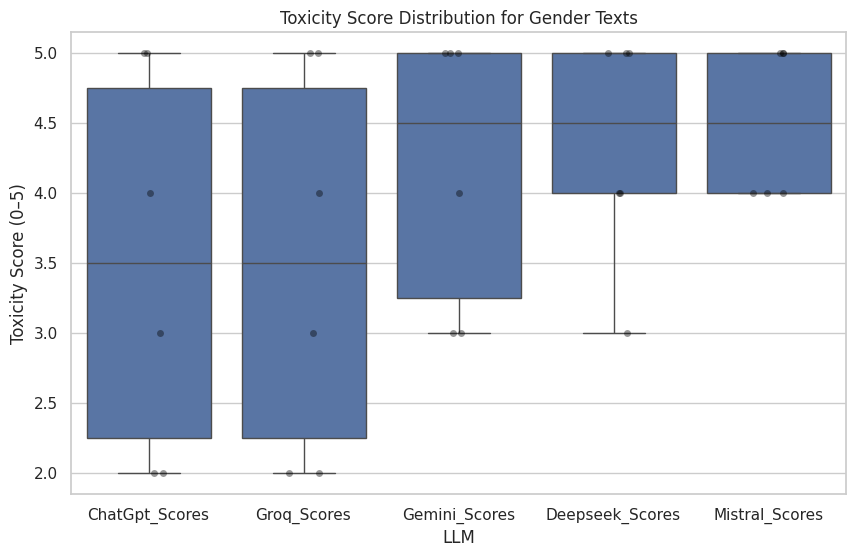

In [ ]:
plot_score_distribution(merged, "gender")

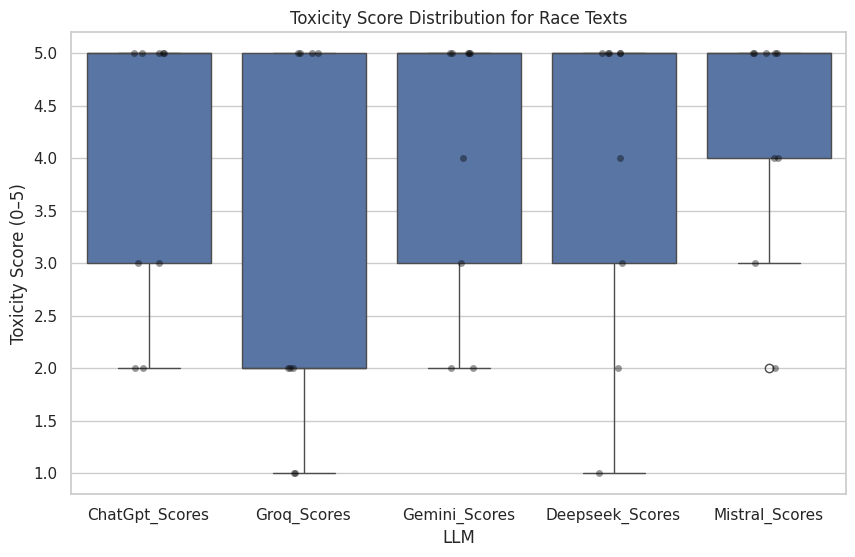

In [ ]:
plot_score_distribution(merged, "race")

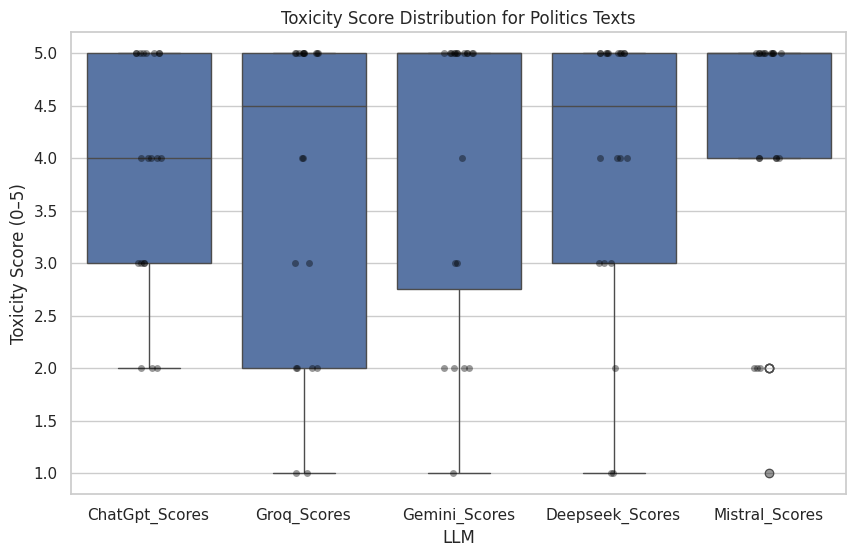

In [ ]:
plot_score_distribution(merged, "politics")

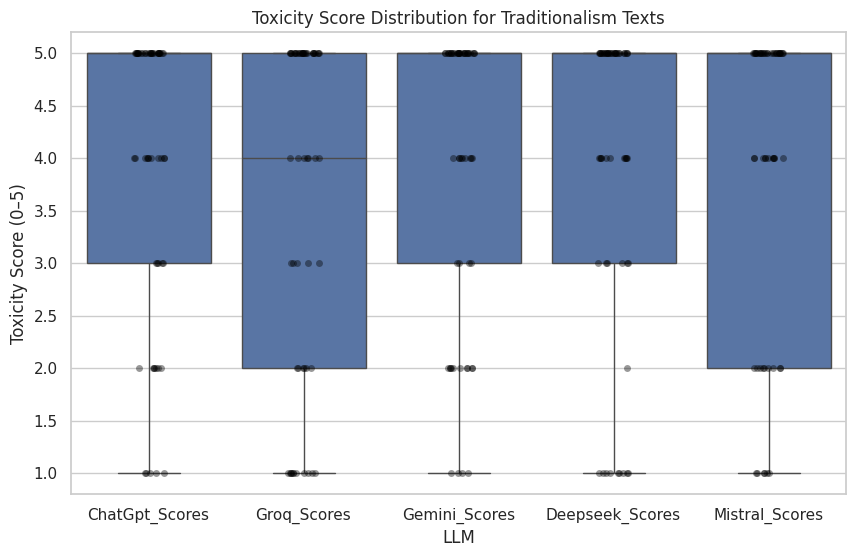

In [ ]:
plot_score_distribution(merged, "traditionalism")

# **What attribute each LLM agrees in each instance**

In [82]:
def get_agreement_groups(label, toxic_pole):
    if pd.isna(label) or pd.isna(toxic_pole):
        return "None"

    pole_dict = safe_parse_pole(toxic_pole)
    if not pole_dict:
        return "None"

    groups = [group for group, pole_label in pole_dict.items() if pole_label == label]
    return ", ".join(groups) if groups else "None"

In [83]:
merged["ChatGpt_Agree"]  = merged.apply(lambda row: get_agreement_groups(row["ChatGpt_Label"],   row["toxic_pole"]), axis=1)
merged["Groq_Agree"]     = merged.apply(lambda row: get_agreement_groups(row["Groq_Label"],    row["toxic_pole"]), axis=1)
merged["Gemini_Agree"]   = merged.apply(lambda row: get_agreement_groups(row["Gemini_Label"],  row["toxic_pole"]), axis=1)
merged["Deepseek_Agree"] = merged.apply(lambda row: get_agreement_groups(row["Deepseek_Label"],row["toxic_pole"]), axis=1)
merged["Mistral_Agree"]  = merged.apply(lambda row: get_agreement_groups(row["Mistral_Label"], row["toxic_pole"]), axis=1)

In [84]:
merged.head()

,Unnamed: 0.1,Unnamed: 0,tweet,DFU,dimension,toxic_pole,ChatGpt_Label,ChatGpt_Scores,Groq_Label,Groq_Scores,...,Deepseek_Scores,Mistral_Label,Mistral_Scores,LLMs_Agree,LLMs_avg_score,ChatGpt_Agree,Groq_Agree,Gemini_Agree,Deepseek_Agree,Mistral_Agree
0,0,0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}",toxic,4,toxic,3,...,5,toxic,5,woman,4.4,woman,woman,woman,woman,woman
1,1,1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}",toxic,5,toxic,5,...,5,toxic,5,woman,5.0,woman,woman,woman,woman,woman
2,2,2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}",civil,2,civil,2,...,4,toxic,4,man,3.2,woman,woman,man,man,man
3,3,3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}",toxic,3,civil,2,...,4,toxic,4,man,3.2,man,woman,man,man,man
4,4,4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}",civil,2,toxic,4,...,3,toxic,4,man,3.2,woman,man,man,man,man


In [85]:
 merged.to_excel('LLMs_Agree2.xlsx')

# **Percentage of aggrement**

In [87]:
import ast
from collections import Counter
from IPython.display import display

def parse_toxic_pole(pole):
    if pd.isna(pole):
        return {}
    try:
        parsed = ast.literal_eval(pole) if isinstance(pole, str) else pole
        if isinstance(parsed, dict):
            return {str(k).strip("'\" "): str(v).strip("'\" ") for k, v in parsed.items()}
    except Exception:
        pass

    try:
        return {g.strip("'\" "): l.strip("'\" ")
                for g, l in [p.split(":") for p in pole.strip("{}").split(",")]}
    except Exception:
        return {}


In [88]:
def get_agreement_groups(label, toxic_pole):
    if pd.isna(label) or pd.isna(toxic_pole):
        return None
    pole_dict = parse_toxic_pole(toxic_pole)
    return [g for g, l in pole_dict.items() if l.lower() == str(label).lower()] or None

for model in ["ChatGpt", "Groq", "Gemini", "Deepseek", "Mistral"]:
    merged[f"{model}_Agree"] = merged.apply(
        lambda row, m=model: get_agreement_groups(row[f"{m}_Label"], row["toxic_pole"]),
        axis=1
    )

def compute_agreement_percentages(df, agree_col, group_totals):
    counts = (
        df[agree_col]
        .explode()
        .dropna()
        .astype(str)
        .str.strip("'\" ")
        .value_counts()
    )
    return {g: (counts.get(g, 0) / total) * 100 if total > 0 else 0
            for g, total in group_totals.items()}

In [89]:
all_tables = []

for dim in merged["dimension"].unique():
    df_dim = merged[merged["dimension"] == dim]

    # Count how many times each group appears in this dimension
    group_totals = Counter()
    for pole in df_dim["toxic_pole"].dropna():
        group_totals.update(parse_toxic_pole(pole).keys())

    # Compute per-model agreements
    results = {model: compute_agreement_percentages(df_dim, f"{model}_Agree", group_totals)
               for model in ["ChatGpt", "Groq", "Gemini", "Deepseek", "Mistral"]}

    df_results = pd.DataFrame(results).fillna(0).astype(float)
    df_results["dimension"] = dim
    df_results["examples"] = df_results.index.map(group_totals)  # add counts
    all_tables.append(df_results.reset_index().rename(columns={"index": "group"}))

sensitivity_merged = pd.concat(all_tables, ignore_index=True)

In [90]:
numeric_cols = ["ChatGpt", "Groq", "Gemini", "Deepseek", "Mistral"]
display(
    sensitivity_merged.style
    .background_gradient(cmap="Blues", subset=numeric_cols)
    .format({col: "{:.1f}%" for col in numeric_cols})
)


,group,ChatGpt,Groq,Gemini,Deepseek,Mistral,dimension,examples
0,man,33.3%,33.3%,66.7%,66.7%,66.7%,gender,6
1,woman,66.7%,66.7%,33.3%,33.3%,33.3%,gender,6
2,black,66.7%,33.3%,66.7%,66.7%,77.8%,race,9
3,white,66.7%,88.9%,66.7%,66.7%,55.6%,race,9
4,hisp,50.0%,0.0%,0.0%,0.0%,50.0%,race,2
5,other,0.0%,0.0%,0.0%,0.0%,0.0%,race,1
6,low,76.9%,84.6%,76.9%,73.1%,76.9%,traditionalism,26
7,high,90.0%,94.0%,90.0%,88.0%,90.0%,traditionalism,50
8,very high,87.8%,89.8%,87.8%,83.7%,89.8%,traditionalism,49
9,very low,66.7%,77.8%,66.7%,66.7%,66.7%,traditionalism,9


# **Cohen's Kappa**

In [91]:
def safe_kappa(y1, y2):
    y1, y2 = list(y1), list(y2)
    if len(set(y1)) == 1 and len(set(y2)) == 1:
        return 1.0 if y1[0] == y2[0] else 0.0
    try:
        return cohen_kappa_score(y1, y2)
    except Exception:
        return np.nan

In [92]:
models = ["ChatGpt_Label", "Groq_Label", "Gemini_Label", "Deepseek_Label", "Mistral_Label"]

overall_pairs = []
for i in range(len(models)):
    for j in range(i + 1, len(models)):
        m1, m2 = models[i], models[j]
        pairs = merged[[m1, m2]].dropna()
        if not pairs.empty:
            kappa = safe_kappa(pairs[m1], pairs[m2])
            overall_pairs.append({"Model A": m1, "Model B": m2, "Kappa": kappa})

df_overall = pd.DataFrame(overall_pairs)
df_overall["Kappa"] = df_overall["Kappa"].round(3)

print("=== Overall Cohen’s Kappa by Model Pair ===")
display(df_overall)


=== Overall Cohen’s Kappa by Model Pair ===


,Model A,Model B,Kappa
0,ChatGpt_Label,Groq_Label,0.645
1,ChatGpt_Label,Gemini_Label,0.617
2,ChatGpt_Label,Deepseek_Label,0.784
3,ChatGpt_Label,Mistral_Label,0.772
4,Groq_Label,Gemini_Label,0.652
5,Groq_Label,Deepseek_Label,0.574
6,Groq_Label,Mistral_Label,0.675
7,Gemini_Label,Deepseek_Label,0.726
8,Gemini_Label,Mistral_Label,0.718
9,Deepseek_Label,Mistral_Label,0.754


Cohen’s Kappa shows all models have at least moderate agreement, mostly substantial. ChatGPT, Deepseek, and Mistral align most strongly (0.75–0.78). Gemini also matches well with Deepseek and Mistral. Groq is the least consistent, especially with Deepseek (0.57). Overall, agreement is good, but Groq diverges more than the others.

In [93]:
all_kappa_tables = []

for dim, df_dim in merged.groupby("dimension"):
    kappa_dim = []
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            m1, m2 = models[i], models[j]
            pairs = df_dim[[m1, m2]].dropna()
            if not pairs.empty:
                kappa = safe_kappa(pairs[m1], pairs[m2])
                kappa_dim.append({
                    "dimension": dim,
                    "Model A": m1,
                    "Model B": m2,
                    "Kappa": kappa
                })
    if kappa_dim:
        all_kappa_tables.append(pd.DataFrame(kappa_dim))

df_by_dim = pd.concat(all_kappa_tables, ignore_index=True)
df_by_dim["Kappa"] = df_by_dim["Kappa"].round(3)

print("=== Cohen’s Kappa by Dimension and Model Pair ===")
display(df_by_dim)

=== Cohen’s Kappa by Dimension and Model Pair ===


,dimension,Model A,Model B,Kappa
0,gender,ChatGpt_Label,Groq_Label,0.250
1,gender,ChatGpt_Label,Gemini_Label,0.000
2,gender,ChatGpt_Label,Deepseek_Label,0.000
3,gender,ChatGpt_Label,Mistral_Label,0.000
4,gender,Groq_Label,Gemini_Label,0.000
5,gender,Groq_Label,Deepseek_Label,0.000
6,gender,Groq_Label,Mistral_Label,0.000
7,gender,Gemini_Label,Deepseek_Label,1.000
8,gender,Gemini_Label,Mistral_Label,1.000
9,gender,Deepseek_Label,Mistral_Label,1.000


do a diagram stating the number of instances

Cohen’s Kappa by dimension shows very different patterns. For gender, agreement is extremely inconsistent: most pairs have no agreement (0.0), except Groq–ChatGPT (0.25, slight) and perfect agreement (1.0) among Gemini, Deepseek, and Mistral. For politics, agreement is very strong across all pairs (0.76–1.0), showing consistent labeling across models. For race, results are mixed, with moderate agreement in some cases (0.37–0.61), but also negative kappas (e.g., ChatGPT–Gemini at -0.29, Gemini–Mistral at -0.17), suggesting disagreement. For traditionalism, models generally align well (0.59–0.89), with strongest consistency between ChatGPT and Mistral (0.89). Overall, politics and traditionalism show substantial agreement, gender splits sharply (some perfect, mostly none), and race is the least consistent dimension.

In [94]:
dim_scores = []
for dim, df_dim in merged.groupby("dimension"):
    kappas = []
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            m1, m2 = models[i], models[j]
            pairs = df_dim[[m1, m2]].dropna()
            if not pairs.empty:
                kappas.append(safe_kappa(pairs[m1], pairs[m2]))
    if kappas:
        dim_scores.append({"dimension": dim, "Mean Kappa": np.nanmean(kappas)})

df_dimension = pd.DataFrame(dim_scores)
df_dimension["Mean Kappa"] = df_dimension["Mean Kappa"].round(3)

print("=== Cohen’s Kappa by Dimension ===")
display(df_dimension)

=== Cohen’s Kappa by Dimension ===


,dimension,Mean Kappa
0,gender,0.325
1,politics,0.714
2,race,0.277
3,traditionalism,0.799


Across dimensions, politics (0.836) and traditionalism (0.748) show strong overall agreement between models, while gender (0.325) and especially race (0.277) have much weaker consistency. This suggests labeling is most reliable for politics and traditionalism, but more subjective or inconsistent for gender and race.

In [95]:
from sklearn.metrics.pairwise import cosine_similarity

dim_vectors = {}
for dim, df_dim in merged.groupby("dimension"):
    labels = df_dim[models].astype(str).values.flatten()
    counts = pd.Series(labels).value_counts(normalize=True)  # distribution
    dim_vectors[dim] = counts

all_labels = sorted(set().union(*[v.index for v in dim_vectors.values()]))
dist_matrix = pd.DataFrame({d: dim_vectors[d].reindex(all_labels, fill_value=0)
                            for d in dim_vectors})

cos_sim = cosine_similarity(dist_matrix.T)

df_dim_dim = pd.DataFrame(cos_sim, index=dist_matrix.columns, columns=dist_matrix.columns)
display(df_dim_dim)


,gender,politics,race,traditionalism
gender,1.000000,0.994263,0.980830,0.988618
politics,0.994263,1.000000,0.996046,0.999038
race,0.980830,0.996046,1.000000,0.998983
traditionalism,0.988618,0.999038,0.998983,1.000000


This matrix shows the correlations between the dimensions. All values are extremely high (≥ 0.96), meaning the dimensions are strongly interrelated. Politics and race (0.998) are almost perfectly correlated, and traditionalism also closely tracks all other dimensions (0.99+). Even gender, which had lower agreement in Kappa, still correlates very strongly (≥ 0.96) with the others. Overall, despite differences in labeling consistency per dimension, the underlying dimensions are highly interconnected.

#**Multidimensionality**

In [96]:
import itertools

def count_texts_by_combo(df, dims_list, toxcol="toyou", min_agree=3):
    results = []
    for dims in dims_list:
        count = df.apply(lambda r: dfu_condition_multi(r, dims, toxcol, min_agree), axis=1).sum()
        results.append({"dims": " × ".join(dims), "count": int(count)})
    return pd.DataFrame(results).sort_values("count", ascending=False)

def dfu_condition_multi(row, dims=("annotatorRace","annotatorGender"), toxcol="toyou", min_agree=3):
    scores = row[toxcol]
    if scores is None or len(scores) <= 2:
        return False
    if dfu(pdf(scores, scale)) == 0:
        return False

    subgroup_dict = {}
    for i in range(len(scores)):
        key = tuple(row[d][i] for d in dims)
        subgroup_dict.setdefault(key, []).append(scores[i])

    unimodal_count = 0
    for vals in subgroup_dict.values():
        if len(vals) >= 2 and dfu(pdf(vals, scale)) == 0:
            unimodal_count += 1

    return unimodal_count >= min_agree


dims = ["annotatorRace", "annotatorGender", "annotatorPolitics", "traditionalism"]
pairs = list(itertools.combinations(dims, 2))

df_counts = count_texts_by_combo(shortlist, pairs, min_agree=3)
print(df_counts)


                                  dims  count
1    annotatorRace × annotatorPolitics      4
0      annotatorRace × annotatorGender      2
2       annotatorRace × traditionalism      0
3  annotatorGender × annotatorPolitics      0
4     annotatorGender × traditionalism      0
5   annotatorPolitics × traditionalism      0


In [97]:
def inspect_all_combos(df, dims=("annotatorRace","annotatorGender","annotatorPolitics","traditionalism"),
                       toxcol="toyou", min_agree=3, n=3):
    pairs = list(itertools.combinations(dims, 2))

    for pair in pairs:
        print("\n" + "="*60)
        print(f"Combination: {pair}")

        # Filter dataset for this pair
        df_pair = df[df.apply(lambda r: dfu_condition_multi(r, pair, toxcol, min_agree), axis=1)]
        print(f"Surviving texts: {len(df_pair)}")

        if len(df_pair) == 0:
            continue

        shown = 0
        for idx, row in df_pair.iterrows():
            scores = row[toxcol]
            dfu_all = dfu(pdf(scores, scale))

            subgroup_dict = {}
            for i in range(len(scores)):
                key = tuple(row[d][i] for d in pair)
                subgroup_dict.setdefault(key, []).append(scores[i])

            # Evaluate DFU in subgroups
            subgroup_results = {k: (v, dfu(pdf(v, scale))) for k,v in subgroup_dict.items() if len(v) >= 2}

            print(f"\n--- Example {shown+1} (index {idx}) ---")
            print(f"Tweet: {row.get('tweet','N/A')}")
            print(f"DFU(all) = {dfu_all:.3f}")
            for pole, (vals, dfu_val) in subgroup_results.items():
                print(f"  {pole}: {vals}, DFU={dfu_val:.3f}")

            shown += 1
            if shown >= n:
                break


In [98]:
inspect_all_combos(shortlist, min_agree=3, n=5)



Combination: ('annotatorRace', 'annotatorGender')
Surviving texts: 2

--- Example 1 (index 93) ---
Tweet: Bitches be too mad bitch get some money and move out the hood you fake ballers:woman_golfing_medium-dark_skin_tone::woman_shrugging_medium-dark_skin_tone:
DFU(all) = 0.500
  ('black', 'woman'): [5, 5], DFU=0.000
  ('white', 'man'): [2, 1], DFU=0.000
  ('white', 'woman'): [4, 4], DFU=0.000

--- Example 2 (index 516) ---
Tweet: boy i've never been in a fight before but i fr just wanted to start one w some hartshorne kids at subway
DFU(all) = 0.667
  ('black', 'man'): [4, 3], DFU=0.000
  ('white', 'man'): [3, 3], DFU=0.000
  ('white', 'woman'): [1, 1], DFU=0.000

Combination: ('annotatorRace', 'annotatorPolitics')
Surviving texts: 4

--- Example 1 (index 32) ---
Tweet: "My Grammy never stops talking. She will talk to you for an hour straight with only the ""mhmm"" responses n give no fucks."
DFU(all) = 0.333
  ('black', -0.5): [2, 1], DFU=0.000
  ('white', 0.5): [3, 3], DFU=0.000
  (

# **Debiasing the LLMs**

In [99]:
import json
import pandas as pd
from tqdm import tqdm

def run_debias(df, model_name, safe_completion_fn, label_col, score_col, output_file):
    records = []

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {model_name} tweets"):
        dimension = row["dimension"]
        tweet = row["tweet"]
        base = row.to_dict()

        if dimension in persona_map:
            personas = persona_map[dimension]
            prompt = make_persona_prompt(tweet, dimension, personas)

            raw = safe_completion_fn(prompt, max_tokens=200)  # more tokens for JSON

            results = parse_output(raw, personas)
            labels_dict, scores_dict, same_label_dict, same_score_dict = {}, {}, {}, {}

            for persona in personas:
                label = results.get(persona, {}).get("label")
                score = results.get(persona, {}).get("score")

                labels_dict[persona] = label
                scores_dict[persona] = score
                same_label_dict[persona] = (label == row[label_col])
                same_score_dict[persona] = (score == row[score_col])

        else:
            labels_dict = scores_dict = same_label_dict = same_score_dict = None

        base[f"{model_name}_Persona_Labels"] = labels_dict
        base[f"{model_name}_Persona_Scores"] = scores_dict
        base[f"{model_name}_Persona_SAME_AS_BEFORE_LABEL"] = same_label_dict
        base[f"{model_name}_Persona_SAME_AS_BEFORE_SCORE"] = same_score_dict

        records.append(base)

        # Batch update
        if (i + 1) % 10 == 0:
            print(f"✅ {model_name}: Processed {i+1}/{len(df)} tweets")

    persona_expanded = pd.DataFrame(records)
    persona_expanded.to_excel(output_file, index=False)

    print(f"\n🎉 Finished and saved to {output_file}!")
    return persona_expanded


In [100]:
persona_map = {
    "gender": ["man", "woman"],
    "politics": ["far left", "left", "center", "right", "far right"],
    "race": ["white", "black","other"],  # example
    "traditionalism": ["low", "high"]
}

In [101]:
import json, re, time, random

# ---------- Prompt Builder ----------
def make_persona_prompt(tweet, dimension, personas):
    persona_list = "\n".join([f'- "{p}"' for p in personas])
    return f"""
You are an annotation system. DO NOT output anything except valid JSON.

Tweet: "{tweet}"

Personas in the {dimension} dimension:
{persona_list}

For each persona, classify the tweet as "toxic" or "civil" and assign a score (1–5).

Return EXACTLY valid JSON like this:
{{
  "man": {{"label": "toxic", "score": 4}},
  "woman": {{"label": "civil", "score": 1}}
}}
"""

def parse_output(raw, personas):
    """Parse model output: handle JSON code fences, fallback to regex."""

    # Step 1: Remove Markdown code fences if present
    raw = raw.strip()
    if raw.startswith("```"):
        raw = re.sub(r"^```[a-zA-Z]*\n?", "", raw)  # remove opening fence
        raw = re.sub(r"\n?```$", "", raw)           # remove closing fence

    # Step 2: Try JSON directly
    try:
        return json.loads(raw)
    except:
        pass

    # Step 3: Extract JSON-looking block if mixed with text
    match = re.search(r"\{[\s\S]*\}", raw)
    if match:
        try:
            return json.loads(match.group(0))
        except:
            pass

    # Step 4: Persona-based regex fallback
    results = {}
    for p in personas:
        label_match = re.search(rf"{p}.*?(toxic|civil)", raw, re.IGNORECASE)
        score_match = re.search(rf"{p}.*?([1-5])", raw)
        results[p] = {
            "label": label_match.group(1).lower() if label_match else None,
            "score": int(score_match.group(1)) if score_match else None,
        }
    return results




# ------------------ SAFE COMPLETION ------------------
def safe_completion(prompt, client, model="llama-3.1-8b-instant", max_tokens=128, retries=5):
    """
    Unified safe completion for any model behind an OpenAI-compatible client.
    """
    for attempt in range(retries):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
            )
            return resp.choices[0].message.content.strip()

        except Exception as exc:
            if attempt == retries - 1:
                raise
            wait_time = 2 ** attempt + random.random()
            print(f"⚠️ Retry {attempt+1} after error: {exc} (waiting {wait_time:.1f}s)")
            time.sleep(wait_time)

    return "<FAILED>"


In [102]:
persona_bias = pd.read_excel("/content/merged_tables_LLMs.xlsx")

**Groq**

In [ ]:
# Keep only needed columns
groq_debias = persona_bias[
    ["tweet", "DFU", "dimension", "toxic_pole", "Groq_Label", "Groq_Scores"]
]

groq_debias.head()


,tweet,DFU,dimension,toxic_pole,Groq_Label,Groq_Scores
0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}",toxic,3
1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}",toxic,5
2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}",civil,2
3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}",civil,2
4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}",toxic,4


In [ ]:
from openai import OpenAI
from google.colab import userdata

GROQ_KEY = userdata.get("groq_key")
client = OpenAI(api_key=GROQ_KEY, base_url="https://api.groq.com/openai/v1")


In [ ]:
from functools import partial

safe_completion_groq = partial(safe_completion, client=client, model="llama-3.1-8b-instant")

# Now run
persona_expanded_groq = run_debias(
    groq_debias,
    model_name="Groq",
    safe_completion_fn=safe_completion_groq,
    label_col="Groq_Label",
    score_col="Groq_Scores",
    output_file="groq_debias.xlsx"
)

Processing Groq tweets:  12%|█▏        | 11/92 [00:02<00:19,  4.22it/s]

✅ Groq: Processed 10/92 tweets


Processing Groq tweets:  23%|██▎       | 21/92 [00:05<00:15,  4.44it/s]

✅ Groq: Processed 20/92 tweets


Processing Groq tweets:  33%|███▎      | 30/92 [00:13<01:37,  1.56s/it]

✅ Groq: Processed 30/92 tweets


Processing Groq tweets:  43%|████▎     | 40/92 [00:34<01:54,  2.19s/it]

✅ Groq: Processed 40/92 tweets


Processing Groq tweets:  54%|█████▍    | 50/92 [00:57<01:37,  2.32s/it]

✅ Groq: Processed 50/92 tweets


Processing Groq tweets:  65%|██████▌   | 60/92 [01:19<01:11,  2.24s/it]

✅ Groq: Processed 60/92 tweets


Processing Groq tweets:  76%|███████▌  | 70/92 [01:42<00:49,  2.23s/it]

✅ Groq: Processed 70/92 tweets


Processing Groq tweets:  87%|████████▋ | 80/92 [02:04<00:27,  2.29s/it]

✅ Groq: Processed 80/92 tweets


Processing Groq tweets:  98%|█████████▊| 90/92 [02:32<00:05,  2.90s/it]

✅ Groq: Processed 90/92 tweets


Processing Groq tweets: 100%|██████████| 92/92 [02:38<00:00,  1.72s/it]


🎉 Finished and saved to groq_debias.xlsx!


**Mistral**

In [ ]:
mistral_debias = persona_bias[
    ["tweet", "DFU", "dimension", "toxic_pole", "Mistral_Label", "Mistral_Scores"]
]

mistral_debias.head()

,tweet,DFU,dimension,toxic_pole,Mistral_Label,Mistral_Scores
0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}",toxic,5
1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}",toxic,5
2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}",toxic,4
3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}",toxic,4
4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}",toxic,4


In [ ]:
from openai import OpenAI

MISTRAL_KEY = userdata.get("mistral_key")
client = OpenAI(
    api_key=MISTRAL_KEY,
    base_url="https://api.mistral.ai/v1"
)


In [ ]:
def safe_completion(prompt, model="open-mistral-7b", max_tokens=128):
    for attempt in range(5):  # allow more retries
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
                stream=False,
            )
            return resp.choices[0].message.content.strip()
        except Exception as exc:
            if "Rate limit" in str(exc):
                wait_time = 5 * (attempt + 1)  # exponential backoff
                print(f"⚠️ Rate limit hit, sleeping {wait_time}s...")
                time.sleep(wait_time)
                continue
            if attempt == 4:
                raise
            time.sleep(2 ** attempt + random.random())


In [ ]:
persona_expanded_mistral = run_debias(
    mistral_debias,
    model_name="Mistral",
    safe_completion_fn=safe_completion,
    label_col="Mistral_Label",
    score_col="Mistral_Scores",
    output_file="mistral_debias.xlsx"
)


Processing Mistral tweets:  11%|█         | 10/92 [00:06<00:58,  1.40it/s]

✅ Mistral: Processed 10/92 tweets


Processing Mistral tweets:  22%|██▏       | 20/92 [00:13<00:44,  1.61it/s]

✅ Mistral: Processed 20/92 tweets


Processing Mistral tweets:  33%|███▎      | 30/92 [00:19<00:37,  1.65it/s]

✅ Mistral: Processed 30/92 tweets


Processing Mistral tweets:  43%|████▎     | 40/92 [00:24<00:30,  1.69it/s]

✅ Mistral: Processed 40/92 tweets


Processing Mistral tweets:  54%|█████▍    | 50/92 [00:30<00:24,  1.73it/s]

✅ Mistral: Processed 50/92 tweets


Processing Mistral tweets:  65%|██████▌   | 60/92 [00:36<00:19,  1.68it/s]

✅ Mistral: Processed 60/92 tweets
⚠️ Rate limit hit, sleeping 5s...
⚠️ Rate limit hit, sleeping 10s...
⚠️ Rate limit hit, sleeping 15s...


Processing Mistral tweets:  76%|███████▌  | 70/92 [01:20<00:23,  1.08s/it]

✅ Mistral: Processed 70/92 tweets


Processing Mistral tweets:  87%|████████▋ | 80/92 [01:30<00:11,  1.00it/s]

✅ Mistral: Processed 80/92 tweets


Processing Mistral tweets:  98%|█████████▊| 90/92 [01:39<00:01,  1.15it/s]

✅ Mistral: Processed 90/92 tweets


Processing Mistral tweets: 100%|██████████| 92/92 [01:40<00:00,  1.10s/it]


🎉 Finished and saved to mistral_debias.xlsx!


**Gemini**

In [132]:
gemini_debias = persona_bias[
    ["tweet", "DFU", "dimension", "toxic_pole", "Gemini_Label", "Gemini_Scores"]
]

gemini_debias.head()


,tweet,DFU,dimension,toxic_pole,Gemini_Label,Gemini_Scores
0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}",toxic,5
1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}",toxic,5
2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}",toxic,4
3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}",toxic,3
4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}",toxic,3


In [133]:
from openai import OpenAI
from google.colab import userdata
import time, random

# Client with Google endpoint
client = OpenAI(
    api_key=userdata.get("gemini_key"),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

In [134]:
def safe_completion(prompt, model="gemini-2.0-flash", max_tokens=256):
    for attempt in range(10):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
            )
            return resp.choices[0].message.content.strip()

        except Exception as exc:
            msg = str(exc)

            # Quota / rate limits
            if "RESOURCE_EXHAUSTED" in msg or "429" in msg:
                m = re.search(r"retry in (\d+)", msg)
                wait_time = int(m.group(1)) + 5 if m else 60
                print(f"⚠️ Quota hit, sleeping {wait_time}s...")
                time.sleep(wait_time)
                continue

            # Model overloaded
            if "503" in msg or "overloaded" in msg or "UNAVAILABLE" in msg:
                wait_time = min(60, 10 + attempt * 5)
                print(f"⚠️ Model overloaded, sleeping {wait_time}s (attempt {attempt+1})...")
                time.sleep(wait_time)
                continue

            # Fallback exponential backoff
            if attempt == 9:
                raise
            wait_time = 2 ** attempt + random.random()
            print(f"⚠️ Retry {attempt+1} after error: {exc} (waiting {wait_time:.1f}s)")
            time.sleep(wait_time)

    return "<FAILED>"

In [135]:
persona_expanded_gemini = run_debias(
    df=gemini_debias,
    model_name="Gemini",
    safe_completion_fn=safe_completion,
    label_col="Gemini_Label",
    score_col="Gemini_Scores",
    output_file="gemini_debias.xlsx"
)


Processing Gemini tweets:  11%|█         | 10/92 [00:08<01:09,  1.18it/s]

✅ Gemini: Processed 10/92 tweets


Processing Gemini tweets:  22%|██▏       | 20/92 [00:17<00:50,  1.42it/s]

✅ Gemini: Processed 20/92 tweets


Processing Gemini tweets:  33%|███▎      | 30/92 [00:28<01:12,  1.17s/it]

✅ Gemini: Processed 30/92 tweets


Processing Gemini tweets:  43%|████▎     | 40/92 [00:44<01:32,  1.79s/it]

✅ Gemini: Processed 40/92 tweets


Processing Gemini tweets:  54%|█████▍    | 50/92 [01:04<01:33,  2.22s/it]

✅ Gemini: Processed 50/92 tweets


Processing Gemini tweets:  61%|██████    | 56/92 [01:10<00:45,  1.26s/it]

⚠️ Model overloaded, sleeping 10s (attempt 1)...
⚠️ Model overloaded, sleeping 15s (attempt 2)...


Processing Gemini tweets:  65%|██████▌   | 60/92 [02:00<03:07,  5.87s/it]

✅ Gemini: Processed 60/92 tweets


Processing Gemini tweets:  76%|███████▌  | 70/92 [02:15<00:30,  1.39s/it]

✅ Gemini: Processed 70/92 tweets


Processing Gemini tweets:  87%|████████▋ | 80/92 [02:38<00:21,  1.77s/it]

✅ Gemini: Processed 80/92 tweets


Processing Gemini tweets:  98%|█████████▊| 90/92 [03:01<00:05,  2.64s/it]

✅ Gemini: Processed 90/92 tweets


Processing Gemini tweets: 100%|██████████| 92/92 [03:04<00:00,  2.00s/it]


🎉 Finished and saved to gemini_debias.xlsx!


In [136]:
test=pd.read_excel("gemini_debias.xlsx")
test.head()

,tweet,DFU,dimension,toxic_pole,Gemini_Label,Gemini_Scores,Gemini_Persona_Labels,Gemini_Persona_Scores,Gemini_Persona_SAME_AS_BEFORE_LABEL,Gemini_Persona_SAME_AS_BEFORE_SCORE
0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}",toxic,5,"{'man': 'toxic', 'woman': 'toxic'}","{'man': 4, 'woman': 3}","{'man': True, 'woman': True}","{'man': False, 'woman': False}"
1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}",toxic,5,"{'man': 'toxic', 'woman': 'toxic'}","{'man': 5, 'woman': 5}","{'man': True, 'woman': True}","{'man': True, 'woman': True}"
2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}",toxic,4,"{'man': 'toxic', 'woman': 'toxic'}","{'man': 4, 'woman': 3}","{'man': True, 'woman': True}","{'man': True, 'woman': False}"
3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}",toxic,3,"{'man': 'toxic', 'woman': 'toxic'}","{'man': 4, 'woman': 3}","{'man': True, 'woman': True}","{'man': False, 'woman': True}"
4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}",toxic,3,"{'man': 'toxic', 'woman': 'civil'}","{'man': 4, 'woman': 1}","{'man': True, 'woman': False}","{'man': False, 'woman': False}"


**ChatGPT**

In [104]:
chatgpt_debias = persona_bias[
    ["tweet", "DFU", "dimension", "toxic_pole", "ChatGpt_Label", "ChatGpt_Scores"]
]

chatgpt_debias.head()


,tweet,DFU,dimension,toxic_pole,ChatGpt_Label,ChatGpt_Scores
0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}",toxic,4
1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}",toxic,5
2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}",civil,2
3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}",toxic,3
4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}",civil,2


In [109]:
from openai import OpenAI
import time, random
from google.colab import userdata

OPENAI_KEY = userdata.get("chat_api")
client = OpenAI(api_key=OPENAI_KEY)

def safe_completion_chatgpt(prompt, model="gpt-4o-mini", max_tokens=256):
    for attempt in range(3):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
            )
            return resp.choices[0].message.content.strip()
        except Exception as exc:
            if attempt == 2:
                raise
            print(f"⚠️ ChatGPT Retry {attempt+1} after error: {exc}")
            time.sleep(2 ** attempt + random.random())


In [110]:
persona_expanded_chatgpt = run_debias(
    chatgpt_debias,
    model_name="ChatGpt",
    safe_completion_fn=safe_completion_chatgpt,
    label_col="ChatGpt_Label",
    score_col="ChatGpt_Scores",
    output_file="chatgpt_debias.xlsx"
)


Processing ChatGpt tweets:  11%|█         | 10/92 [00:19<02:33,  1.87s/it]

✅ ChatGpt: Processed 10/92 tweets


Processing ChatGpt tweets:  22%|██▏       | 20/92 [00:35<01:51,  1.55s/it]

✅ ChatGpt: Processed 20/92 tweets


Processing ChatGpt tweets:  33%|███▎      | 30/92 [00:47<01:07,  1.09s/it]

✅ ChatGpt: Processed 30/92 tweets


Processing ChatGpt tweets:  43%|████▎     | 40/92 [00:59<01:10,  1.35s/it]

✅ ChatGpt: Processed 40/92 tweets


Processing ChatGpt tweets:  54%|█████▍    | 50/92 [01:10<00:45,  1.07s/it]

✅ ChatGpt: Processed 50/92 tweets


Processing ChatGpt tweets:  65%|██████▌   | 60/92 [01:22<00:42,  1.32s/it]

✅ ChatGpt: Processed 60/92 tweets


Processing ChatGpt tweets:  76%|███████▌  | 70/92 [01:33<00:24,  1.13s/it]

✅ ChatGpt: Processed 70/92 tweets


Processing ChatGpt tweets:  87%|████████▋ | 80/92 [01:52<00:24,  2.02s/it]

✅ ChatGpt: Processed 80/92 tweets


Processing ChatGpt tweets:  98%|█████████▊| 90/92 [02:16<00:04,  2.29s/it]

✅ ChatGpt: Processed 90/92 tweets


Processing ChatGpt tweets: 100%|██████████| 92/92 [02:20<00:00,  1.52s/it]


🎉 Finished and saved to chatgpt_debias.xlsx!


**DeepSeek**

In [113]:
deepseek_debias = persona_bias[
    ["tweet", "DFU", "dimension", "toxic_pole", "Deepseek_Label", "Deepseek_Scores"]
]

deepseek_debias.head()


,tweet,DFU,dimension,toxic_pole,Deepseek_Label,Deepseek_Scores
0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}",toxic,5
1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}",toxic,5
2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}",toxic,4
3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}",toxic,4
4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}",toxic,3


In [114]:
from openai import OpenAI

DEEPSEEK_KEY = userdata.get("deepseek_key")
deepseek_client = OpenAI(
    api_key=DEEPSEEK_KEY,
    base_url="https://api.deepseek.com/v1"
)

def safe_completion_deepseek(prompt, model="deepseek-chat", max_tokens=256):
    for attempt in range(3):
        try:
            resp = deepseek_client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=max_tokens,
            )
            return resp.choices[0].message.content.strip()
        except Exception as exc:
            if attempt == 2:
                raise
            print(f"⚠️ DeepSeek Retry {attempt+1} after error: {exc}")
            time.sleep(2 ** attempt + random.random())


In [116]:
persona_expanded_deepseek = run_debias(
    deepseek_debias,
    model_name="Deepseek",
    safe_completion_fn=safe_completion_deepseek,
    label_col="Deepseek_Label",
    score_col="Deepseek_Scores",
    output_file="deepseek_debias.xlsx"
)


Processing Deepseek tweets:  11%|█         | 10/92 [00:50<07:30,  5.49s/it]

✅ Deepseek: Processed 10/92 tweets


Processing Deepseek tweets:  22%|██▏       | 20/92 [01:41<05:48,  4.85s/it]

✅ Deepseek: Processed 20/92 tweets


Processing Deepseek tweets:  33%|███▎      | 30/92 [02:28<05:00,  4.85s/it]

✅ Deepseek: Processed 30/92 tweets


Processing Deepseek tweets:  43%|████▎     | 40/92 [03:13<03:53,  4.50s/it]

✅ Deepseek: Processed 40/92 tweets


Processing Deepseek tweets:  54%|█████▍    | 50/92 [03:59<03:07,  4.45s/it]

✅ Deepseek: Processed 50/92 tweets


Processing Deepseek tweets:  65%|██████▌   | 60/92 [04:44<02:24,  4.50s/it]

✅ Deepseek: Processed 60/92 tweets


Processing Deepseek tweets:  76%|███████▌  | 70/92 [05:30<01:40,  4.57s/it]

✅ Deepseek: Processed 70/92 tweets


Processing Deepseek tweets:  87%|████████▋ | 80/92 [06:36<01:23,  6.97s/it]

✅ Deepseek: Processed 80/92 tweets


Processing Deepseek tweets:  98%|█████████▊| 90/92 [07:45<00:13,  6.99s/it]

✅ Deepseek: Processed 90/92 tweets


Processing Deepseek tweets: 100%|██████████| 92/92 [07:59<00:00,  5.21s/it]


🎉 Finished and saved to deepseek_debias.xlsx!


# **Insights on debiasing**

In [137]:
llms_agree=pd.read_excel("LLMs_Agree.xlsx")
chat_debias=pd.read_excel("chatgpt_debias.xlsx")
gemini_debias=pd.read_excel("gemini_debias.xlsx")
mistral_debias=pd.read_excel("mistral_debias.xlsx")
groq_debias=pd.read_excel("groq_debias.xlsx")
deepseek_debias=pd.read_excel("deepseek_debias.xlsx")

In [138]:
import ast

def summarize_debias(df, model):
    """
    df = debias dataframe for one LLM (e.g., chat_debias)
    model = model name (string)
    """
    # Convert stringified dicts back to Python dicts
    persona_labels = df[f"{model}_Persona_Labels"].dropna().apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    persona_scores = df[f"{model}_Persona_Scores"].dropna().apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    # Expand dicts into DataFrames
    persona_labels = pd.DataFrame(persona_labels.tolist())
    persona_scores = pd.DataFrame(persona_scores.tolist())

    # Before stats
    avg_before = pd.to_numeric(df[f"{model}_Scores"], errors="coerce").mean()
    toxic_before = (df[f"{model}_Label"].astype(str).str.lower() == "toxic").mean() * 100

    # After stats
    avg_after = persona_scores.stack().mean()
    toxic_after = persona_labels.stack().astype(str).str.lower().eq("toxic").mean() * 100

    # Flip stats
    flips_label = 1 - df[f"{model}_Persona_SAME_AS_BEFORE_LABEL"].apply(
        lambda d: all(ast.literal_eval(d).values()) if isinstance(d, str) else all(d.values())
    ).mean()
    flips_score = 1 - df[f"{model}_Persona_SAME_AS_BEFORE_SCORE"].apply(
        lambda d: all(ast.literal_eval(d).values()) if isinstance(d, str) else all(d.values())
    ).mean()

    return {
        "Model": model,
        "Avg Score Before": round(avg_before, 2),
        "Avg Score After": round(avg_after, 2),
        "% Toxic Before": round(toxic_before, 1),
        "% Toxic After": round(toxic_after, 1),
        "% Label Flips": round(flips_label * 100, 1),
        "% Score Flips": round(flips_score * 100, 1)
    }
summaries = []

for model, df in [
    ("ChatGpt", chat_debias),
    ("Gemini", gemini_debias),
    ("Mistral", mistral_debias),
    ("Groq", groq_debias),
    ("Deepseek", deepseek_debias),
]:
    summaries.append(summarize_debias(df, model))

df_summary = pd.DataFrame(summaries)

print("=== Before vs After Debiasing Summary ===")
display(df_summary)


=== Before vs After Debiasing Summary ===


,Model,Avg Score Before,Avg Score After,% Toxic Before,% Toxic After,% Label Flips,% Score Flips
0,ChatGpt,3.88,4.03,79.3,83.8,56.5,81.5
1,Gemini,3.93,3.93,77.2,84.6,16.3,60.9
2,Mistral,4.02,3.83,78.3,78.3,8.7,43.5
3,Groq,3.58,3.67,67.4,82.8,76.1,90.2
4,Deepseek,3.95,4.03,83.7,87.7,17.4,66.3


In [139]:
import ast

def summarize_debias_by_dimension(df, model):
    """
    df = debias dataframe for one LLM
    model = model name (string)
    """
    results = []
    for dim, group in df.groupby("dimension"):
        # Convert stringified dicts back to dicts
        persona_labels = group[f"{model}_Persona_Labels"].dropna().apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        persona_scores = group[f"{model}_Persona_Scores"].dropna().apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

        # Expand dicts into DataFrames
        persona_labels = pd.DataFrame(persona_labels.tolist())
        persona_scores = pd.DataFrame(persona_scores.tolist())

        # Before stats
        avg_before = pd.to_numeric(group[f"{model}_Scores"], errors="coerce").mean()
        toxic_before = (group[f"{model}_Label"].astype(str).str.lower() == "toxic").mean() * 100

        # After stats
        avg_after = persona_scores.stack().mean()
        toxic_after = persona_labels.stack().astype(str).str.lower().eq("toxic").mean() * 100

        # Flip stats
        flips_label = 1 - group[f"{model}_Persona_SAME_AS_BEFORE_LABEL"].apply(
            lambda d: all(ast.literal_eval(d).values()) if isinstance(d, str) else all(d.values())
        ).mean()
        flips_score = 1 - group[f"{model}_Persona_SAME_AS_BEFORE_SCORE"].apply(
            lambda d: all(ast.literal_eval(d).values()) if isinstance(d, str) else all(d.values())
        ).mean()

        results.append({
            "Model": model,
            "Dimension": dim,
            "Avg Score Before": round(avg_before, 2),
            "Avg Score After": round(avg_after, 2),
            "% Toxic Before": round(toxic_before, 1),
            "% Toxic After": round(toxic_after, 1),
            "% Label Flips": round(flips_label * 100, 1),
            "% Score Flips": round(flips_score * 100, 1)
        })
    return results


# Run for all models
dimension_summaries = []
for model, df in [
    ("ChatGpt", chat_debias),
    ("Gemini", gemini_debias),
    ("Mistral", mistral_debias),
    ("Groq", groq_debias),
    ("Deepseek", deepseek_debias),
]:
    dimension_summaries.extend(summarize_debias_by_dimension(df, model))

df_dimension_summary = pd.DataFrame(dimension_summaries)

print("=== Before vs After Debiasing by Dimension ===")
display(df_dimension_summary)


=== Before vs After Debiasing by Dimension ===


,Model,Dimension,Avg Score Before,Avg Score After,% Toxic Before,% Toxic After,% Label Flips,% Score Flips
0,ChatGpt,gender,3.50,4.17,66.7,100.0,33.3,50.0
1,ChatGpt,politics,3.90,3.88,85.0,83.0,20.0,95.0
2,ChatGpt,race,3.89,4.26,77.8,88.9,33.3,55.6
3,ChatGpt,traditionalism,3.91,4.22,78.9,77.5,75.4,84.2
4,Gemini,gender,4.17,3.67,100.0,91.7,16.7,83.3
5,Gemini,politics,3.95,3.86,75.0,84.0,15.0,80.0
6,Gemini,race,4.00,4.33,77.8,100.0,22.2,44.4
7,Gemini,traditionalism,3.89,3.92,75.4,80.7,15.8,54.4
8,Mistral,gender,4.50,3.83,100.0,100.0,0.0,66.7
9,Mistral,politics,4.10,4.01,80.0,85.0,5.0,45.0


In [140]:
import ast

def compute_flip_rates(df, model):
    """Compute overall flip rates for one model."""
    flip_label_rate = 1 - df[f"{model}_Persona_SAME_AS_BEFORE_LABEL"].apply(
        lambda d: all(ast.literal_eval(d).values()) if isinstance(d, str) else all(d.values())
    ).mean()

    flip_score_rate = 1 - df[f"{model}_Persona_SAME_AS_BEFORE_SCORE"].apply(
        lambda d: all(ast.literal_eval(d).values()) if isinstance(d, str) else all(d.values())
    ).mean()

    return {
        "Model": model,
        "Label Flip %": round(flip_label_rate * 100, 1),
        "Score Flip %": round(flip_score_rate * 100, 1),
    }


def compute_flip_rates_by_dimension(df, model):
    """Compute flip rates per dimension for one model."""
    results = []
    for dim, group in df.groupby("dimension"):
        flip_label_rate = 1 - group[f"{model}_Persona_SAME_AS_BEFORE_LABEL"].apply(
            lambda d: all(ast.literal_eval(d).values()) if isinstance(d, str) else all(d.values())
        ).mean()

        flip_score_rate = 1 - group[f"{model}_Persona_SAME_AS_BEFORE_SCORE"].apply(
            lambda d: all(ast.literal_eval(d).values()) if isinstance(d, str) else all(d.values())
        ).mean()

        results.append({
            "Model": model,
            "Dimension": dim,
            "Label Flip %": round(flip_label_rate * 100, 1),
            "Score Flip %": round(flip_score_rate * 100, 1),
        })
    return results


# 🔹 Global flip rates (all models)
flip_summaries = []
for model, df in [
    ("ChatGpt", chat_debias),
    ("Gemini", gemini_debias),
    ("Mistral", mistral_debias),
    ("Groq", groq_debias),
    ("Deepseek", deepseek_debias),
]:
    flip_summaries.append(compute_flip_rates(df, model))

df_flip_summary = pd.DataFrame(flip_summaries)

print("=== Global Flip Rates ===")
display(df_flip_summary)


# 🔹 Per-dimension flip rates
flip_dim_summaries = []
for model, df in [
    ("ChatGpt", chat_debias),
    ("Gemini", gemini_debias),
    ("Mistral", mistral_debias),
    ("Groq", groq_debias),
    ("Deepseek", deepseek_debias),
]:
    flip_dim_summaries.extend(compute_flip_rates_by_dimension(df, model))

df_flip_by_dim = pd.DataFrame(flip_dim_summaries)

print("=== Flip Rates by Dimension ===")
display(df_flip_by_dim)


=== Global Flip Rates ===


,Model,Label Flip %,Score Flip %
0,ChatGpt,56.5,81.5
1,Gemini,16.3,60.9
2,Mistral,8.7,43.5
3,Groq,76.1,90.2
4,Deepseek,17.4,66.3


=== Flip Rates by Dimension ===


,Model,Dimension,Label Flip %,Score Flip %
0,ChatGpt,gender,33.3,50.0
1,ChatGpt,politics,20.0,95.0
2,ChatGpt,race,33.3,55.6
3,ChatGpt,traditionalism,75.4,84.2
4,Gemini,gender,16.7,83.3
5,Gemini,politics,15.0,80.0
6,Gemini,race,22.2,44.4
7,Gemini,traditionalism,15.8,54.4
8,Mistral,gender,0.0,66.7
9,Mistral,politics,5.0,45.0


In [146]:
import ast
from collections import Counter

def safe_eval(val):
    """Safely convert string repr of dicts to dict, or return as-is if already dict."""
    if isinstance(val, dict):
        return val
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except Exception:
            return {}
    return {}

def agreement_by_dimension(df, model):
    results = []

    for dim, df_dim in df.groupby("dimension"):
        group_totals = Counter()
        for pole in df_dim["toxic_pole"].dropna():
            group_totals.update(safe_eval(pole).keys())

        # Before agreement
        agree_before = (
            df_dim.apply(
                lambda row: [
                    g for g, l in safe_eval(row["toxic_pole"]).items()
                    if str(l).lower() == str(row[f"{model}_Label"]).lower()
                ]
                if pd.notna(row[f"{model}_Label"]) else [],
                axis=1
            ).explode().value_counts()
        )

        # After agreement
        agree_after = (
            df_dim.apply(
                lambda row: [
                    g for g, l in safe_eval(row["toxic_pole"]).items()
                    if row[f"{model}_Persona_Labels"]
                    and str(l).lower() in [
                        str(v).lower() for v in safe_eval(row[f"{model}_Persona_Labels"]).values()
                        if v is not None
                    ]
                ]
                if pd.notna(row["toxic_pole"]) else [],
                axis=1
            ).explode().value_counts()
        )

        for g, total in group_totals.items():
            before_pct = (agree_before.get(g, 0) / total) * 100 if total > 0 else 0
            after_pct = (agree_after.get(g, 0) / total) * 100 if total > 0 else 0
            results.append({
                "Model": model,
                "Dimension": dim,
                "Group": g,
                "Agreement Before %": round(before_pct, 1),
                "Agreement After %": round(after_pct, 1),
            })

    return pd.DataFrame(results)


In [147]:
agreement_summaries = []
for model, df in [
    ("ChatGpt", chat_debias),
    ("Gemini", gemini_debias),
    ("Mistral", mistral_debias),
    ("Groq", groq_debias),
    ("Deepseek", deepseek_debias),
]:
    agreement_summaries.append(agreement_by_dimension(df, model))

df_agreement = pd.concat(agreement_summaries, ignore_index=True)

print("=== Agreement with Toxic Pole Groups: Before vs After ===")
display(df_agreement)

=== Agreement with Toxic Pole Groups: Before vs After ===


,Model,Dimension,Group,Agreement Before %,Agreement After %
0,ChatGpt,traditionalism,low,76.9,26.9
1,ChatGpt,traditionalism,high,90.0,34.0
2,ChatGpt,traditionalism,very high,87.8,30.6
3,ChatGpt,traditionalism,very low,66.7,44.4
4,Gemini,traditionalism,low,76.9,76.9
5,Gemini,traditionalism,high,90.0,92.0
6,Gemini,traditionalism,very high,87.8,89.8
7,Gemini,traditionalism,very low,66.7,77.8
8,Mistral,traditionalism,low,76.9,80.8
9,Mistral,traditionalism,high,90.0,88.0


In [149]:
def get_agreement_groups(label, toxic_pole):
    if pd.isna(label) or pd.isna(toxic_pole):
        return None
    pole_dict = parse_toxic_pole(toxic_pole)
    return [g for g, l in pole_dict.items() if l.lower() == str(label).lower()] or None

for model in ["ChatGpt", "Groq", "Gemini", "Deepseek", "Mistral"]:
    merged[f"{model}_Agree"] = merged.apply(
        lambda row, m=model: get_agreement_groups(row[f"{m}_Label"], row["toxic_pole"]),
        axis=1
    )

def compute_agreement_percentages(df, agree_col, group_totals):
    counts = (
        df[agree_col]
        .explode()
        .dropna()
        .astype(str)
        .str.strip("'\" ")
        .value_counts()
    )
    return {g: (counts.get(g, 0) / total) * 100 if total > 0 else 0
            for g, total in group_totals.items()}


In [150]:
import ast

def compute_before_after_agreement(df, model):
    """
    For one model (ChatGpt, Gemini, etc.), compute agreement %
    with toxic_pole groups before and after debiasing.
    """
    # --- Before (single label) ---
    df["Agree_Before"] = df.apply(
        lambda row: get_agreement_groups(row[f"{model}_Label"], row["toxic_pole"]),
        axis=1
    )

    # Count totals per group
    group_totals = Counter()
    for pole in df["toxic_pole"].dropna():
        group_totals.update(parse_toxic_pole(pole).keys())

    before = compute_agreement_percentages(df, "Agree_Before", group_totals)

    # --- After (persona labels) ---
    def persona_agreement(row):
        try:
            labels = row[f"{model}_Persona_Labels"]
            if isinstance(labels, str):
                labels = ast.literal_eval(labels)  # turn back into dict
            if not labels:
                return None
            pole_dict = parse_toxic_pole(row["toxic_pole"])
            return [g for g, l in pole_dict.items()
                    if g in labels and str(labels[g]).lower() == str(l).lower()]
        except Exception:
            return None

    df["Agree_After"] = df.apply(persona_agreement, axis=1)
    after = compute_agreement_percentages(df, "Agree_After", group_totals)

    # --- Merge into tidy table ---
    records = []
    for group in group_totals:
        records.append({
            "Model": model,
            "Group": group,
            "Agreement Before %": round(before.get(group, 0), 1),
            "Agreement After %": round(after.get(group, 0), 1),
        })
    return pd.DataFrame(records)


In [151]:
agreement_summaries = []
for model, df in [
    ("ChatGpt", chat_debias),
    ("Gemini", gemini_debias),
    ("Mistral", mistral_debias),
    ("Groq", groq_debias),
    ("Deepseek", deepseek_debias),
]:
    agreement_summaries.append(compute_before_after_agreement(df, model))

df_agreement = pd.concat(agreement_summaries, ignore_index=True)
display(df_agreement)


,Model,Group,Agreement Before %,Agreement After %
0,ChatGpt,man,33.3,66.7
1,ChatGpt,woman,66.7,33.3
2,ChatGpt,black,66.7,88.9
3,ChatGpt,white,66.7,55.6
4,ChatGpt,hisp,50.0,0.0
...,...,...,...,...
68,Deepseek,far_left,84.6,0.0
69,Deepseek,left,90.0,85.0
70,Deepseek,right,69.2,69.2
71,Deepseek,far_right,30.0,0.0


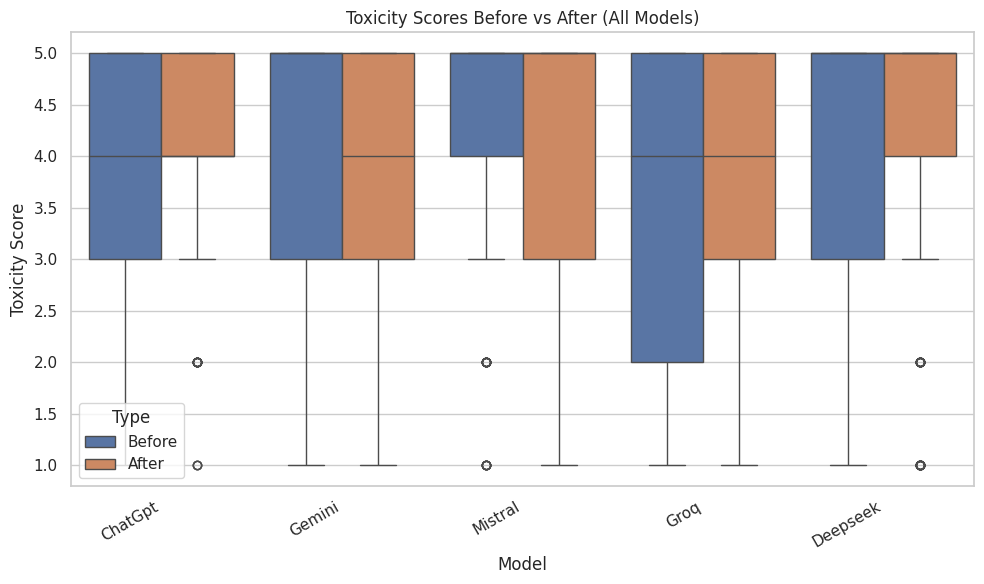

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ast

def expand_scores(df, model):
    """Flatten before/after scores into long-form DataFrame."""
    records = []

    for _, row in df.iterrows():
        dim = row["dimension"]

        # --- Before ---
        score_before = pd.to_numeric(row.get(f"{model}_Scores"), errors="coerce")
        if not pd.isna(score_before):
            records.append({
                "Model": model,
                "Type": "Before",
                "Score": score_before
            })

        # --- After (persona dicts) ---
        persona_scores = row.get(f"{model}_Persona_Scores")
        if isinstance(persona_scores, str):
            try:
                persona_scores = ast.literal_eval(persona_scores)
            except Exception:
                persona_scores = None

        if isinstance(persona_scores, dict):
            for _, s in persona_scores.items():
                if s is not None:
                    records.append({
                        "Model": model,
                        "Type": "After",
                        "Score": s
                    })

    return pd.DataFrame(records)


def plot_overall_boxplots(df_list):
    """Plot Before vs After scores for all models (boxplot)."""
    all_expanded = []
    for model, df in df_list:
        all_expanded.append(expand_scores(df, model))
    all_expanded = pd.concat(all_expanded, ignore_index=True)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=all_expanded, x="Model", y="Score", hue="Type")
    plt.xlabel("Model")
    plt.ylabel("Toxicity Score")
    plt.title("Toxicity Scores Before vs After (All Models)")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()


# Example usage
models_data = [
    ("ChatGpt", chat_debias),
    ("Gemini", gemini_debias),
    ("Mistral", mistral_debias),
    ("Groq", groq_debias),
    ("Deepseek", deepseek_debias),
]

plot_overall_boxplots(models_data)


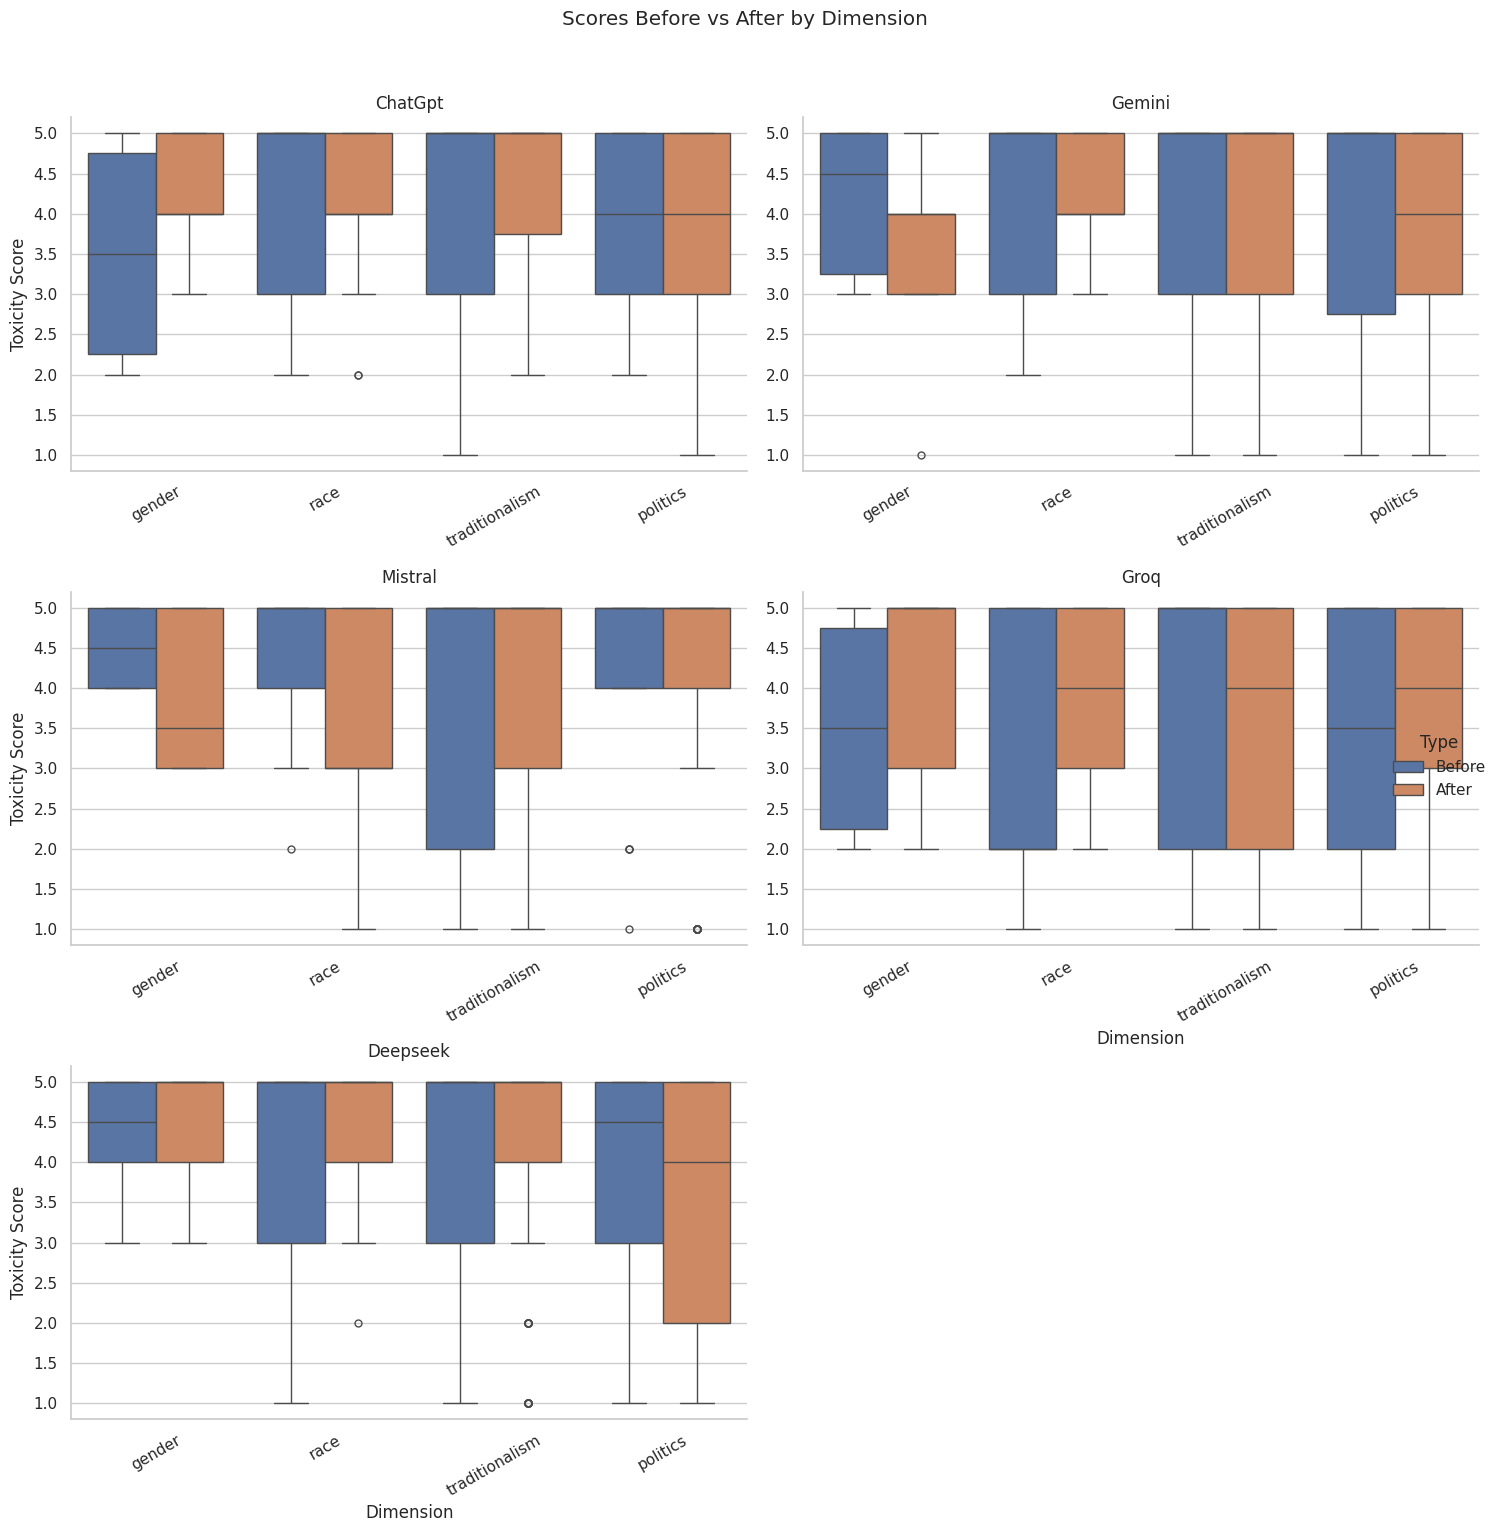

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ast

def expand_scores(df, model):
    """
    Flatten before/after scores for plotting.
    Returns long-form DataFrame with columns:
    [Model, Dimension, Type (Before/After), Score]
    """
    records = []

    for _, row in df.iterrows():
        dim = row["dimension"]

        # --- Before ---
        score_before = pd.to_numeric(row.get(f"{model}_Scores"), errors="coerce")
        if not pd.isna(score_before):
            records.append({
                "Model": model,
                "Dimension": dim,
                "Type": "Before",
                "Score": score_before
            })

        # --- After (persona dicts) ---
        persona_scores = row.get(f"{model}_Persona_Scores")
        if isinstance(persona_scores, str):
            try:
                persona_scores = ast.literal_eval(persona_scores)
            except Exception:
                persona_scores = None

        if isinstance(persona_scores, dict):
            for _, s in persona_scores.items():
                if s is not None:
                    records.append({
                        "Model": model,
                        "Dimension": dim,
                        "Type": "After",
                        "Score": s
                    })

    return pd.DataFrame(records)


def plot_dimension_boxplots(df_list):
    """
    Plot Before vs After scores per dimension, faceted by model.
    """
    all_expanded = []
    for model, df in df_list:
        all_expanded.append(expand_scores(df, model))
    all_expanded = pd.concat(all_expanded, ignore_index=True)

    # Ensure Dimension is categorical with fixed order
    dims = list(all_expanded["Dimension"].unique())
    all_expanded["Dimension"] = pd.Categorical(
        all_expanded["Dimension"], categories=dims, ordered=True
    )

    g = sns.catplot(
        data=all_expanded, kind="box",
        x="Dimension", y="Score", hue="Type", col="Model",
        col_wrap=2, sharey=False, sharex=False, height=5, aspect=1.4
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Dimension", "Toxicity Score")

    # Rotate labels safely (now each facet has its own)
    for ax in g.axes.flat:
        ax.tick_params(axis="x", rotation=30)

    g.fig.suptitle("Scores Before vs After by Dimension", y=1.02)
    plt.tight_layout()
    plt.show()



# Example usage (replace with your actual DataFrames)
models_data = [
    ("ChatGpt", chat_debias),
    ("Gemini", gemini_debias),
    ("Mistral", mistral_debias),
    ("Groq", groq_debias),
    ("Deepseek", deepseek_debias),
]

plot_dimension_boxplots(models_data)
